# 02477 Exercise 3: Bayesian Linear regression

In [1]:
%matplotlib inline
import jax.numpy as jnp
from jax import value_and_grad
from jax import grad
from jax import random
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as snb
from scipy.stats import multivariate_normal

snb.set_theme(font_scale=1.25)

### Overview

The purpose of this exercise is to become familiar with Bayesian linear regression and reinforce the basic concepts of Bayesian inference. 
In the exercise, you will implement several parts of Bayesian linear regression pipeline. However, remember that the purpose of the exercise is to study and understand the key equations for Bayesian linear regression as well as to learn how to use them. 
Besides being useful for practical purposes, the code also allows you to build intuition, e.g. by investigating what happens when you change different parameters etc. So think of the code as a tool for understanding the models and their key equations and not only as an end-product.

**Content**

- Part 1: Visualizing the prior, likelihood and posterior
- Part 2: Implementing the posterior distribution
- Part 3: The posterior predictive distribution
- Part 4: Modelling the number of Airline passengers





**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.



### Bayesian linear regression

Linear regression is perhaps the most common technique in applied statistics and machine learning for modelling the relationship between set of a covariates $\left\lbrace \mathbf{x}_n \right\rbrace_{n=1}^N$ and a response variable $\left\lbrace y_n \right\rbrace_{n=1}^N$. Rather than modelling the relationship between $\mathbf{x}_n$ and $y_n$ directly, we often apply a transformation $\phi$ to the input vectors $\mathbf{x}_n$ first. That is, we often use $\mathbf{\phi}_n = \mathbf{\phi}(\mathbf{x}_n)$ as input to regression model rather than $\mathbf{x}_n$ directly:

\begin{align*}
y_n = f(\mathbf{x}_n) + e_n = \phi(\mathbf{x}_n)^T \mathbf{w} + e_n = \mathbf{\phi}_n^T \mathbf{w} + e_n,
\end{align*}

where $f(\mathbf{x_n}) \equiv \mathbf{\phi}_n^T \mathbf{w}$.


More generally, let $\mathbf{\Phi} \in \mathbb{R}^{N \times D}$ be a **design matrix** and let  $\mathbf{y} \in \mathbb{R}^N$ be the response variables, then the linear regression model is given by

\begin{align*}
\mathbf{y}= \mathbf{\Phi}\mathbf{w} + \mathbf{e},
\end{align*}


where $\mathbf{w} \in \mathbb{R}^D$ is the regression weights and $\mathbf{e} \in \mathbb{R}^N$ is a noise vector. In this exercise, we will only look at additive isotropic Gaussian noise models, i.e. $e_n \sim \mathcal{N}(0, \sigma^2)$, but later we will study more general set-ups. 

Recall, the **maximum likelihood estimator** of the weights $\mathbf{w}$ is given by

\begin{align*}
\hat{\mathbf{w}}_{\text{MLE}} = \left(\mathbf{\Phi}^T \mathbf{\Phi}\right)^{-1} \mathbf{\Phi}^T \mathbf{y}
\end{align*}

We will now turn to the Bayesian treatment. Assuming isotropic Gaussian noise and imposing a multivariate Gaussian prior on $\mathbf{w} \sim \mathcal{N}\left(\mathbf{m}_0, \mathbf{S}_0\right)$ gives rise to the following joint distribution

\begin{align*}
p(\mathbf{y}, \mathbf{w}) = p\left(\mathbf{y}|\mathbf{w}\right)p\left(\mathbf{w}\right) = \mathcal{N}\left(\mathbf{y}\big|\mathbf{\Phi}\mathbf{w}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{w}\big|\mathbf{m}_0, \mathbf{S}_0\right),
\end{align*}

where $\sigma^2$ is the noise variance. We will follow Bishop's notation and use the **noise precision** $\beta = \frac{1}{\sigma^2}$ to parametrize the noise variance.


_________________
#### The posterior distribution 

In contrast to the model we worked with last week, this model is an example of a **conjugate** model, meaning that the posterior distribution will also be a Gaussian distribution given by:

\begin{align*}
p(\mathbf{w}|\mathbf{y}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S})
\end{align*}

where the posterior covariance is given by
\begin{align*}
    \mathbf{S} &= \left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\tag{1}
\end{align*}
and the posterior mean
\begin{align*}
\mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{y}.  \tag{2}
\end{align*}
_________________________

##### In Python: 
- y is the vector of target observations 
  - shape (N,) or (N, 1) with broadcasting, where N is the number of observations
  - The target observations are the values we want to predict or model.
- Φ is the design matrix (basis function matrix) 
  - shape (N, M), where N is the number of data points and M is the number of basis functions (parameters).
  - The design matrix is constructed by applying the basis function to each data point in the input space.
  - 
  - In python it is done in a following way: 
   ```python
    def design_matrix(X, basis_function):
         return np.array([basis_function(x) for x in X])
    ```
- β is the precision (inverse variance) of the likelihood noise
  - shape (1, 1) or (1,) with broadcasting, where 1 is the number of features. 
- S0 is the prior covariance matrix for the weights w 
  - shape (M, M), where M is the number of basis functions (parameters).
  - The prior covariance matrix is a square matrix that describes the uncertainty in the prior distribution of the weights.
  - In python it is done in a following way: 
   ```python
    def prior_covariance_matrix(S0, M):
         return np.eye(M) * S0
    ```
- w is the weight vector (shape (M,) or (M, 1)).
  - The weight vector is the set of parameters we want to learn from the data.
- m is the posterior mean vector (shape (M,) or (M, 1)).
  - The posterior mean vector is the expected value of the weights given the data and the prior distribution.
  - In python it is done in a following way: 
   ```python
    def posterior_mean(S, beta, Phi, y):
         return beta * S @ Phi.T @ y
    ```
- S is the posterior covariance matrix (shape (M, M)).
 - The posterior covariance matrix is a square matrix that describes the uncertainty in the posterior distribution of the weights.
 - In python it is done in a following way: 
   ```python
    def posterior_covariance(S0, beta, Phi):
         return np.linalg.inv(np.linalg.inv(S0) + beta * Phi.T @ Phi)
    ``` 


_____________

The **posterior distribution** $p(\mathbf{w}|\mathbf{y})$ quantifies our knowledge of the parameter after having observed the data $\mathbf{y}$. Hence, we can use the posterior distribution to reason about the size of the coefficients in the linear model. For example, we can use the posterior mean as an estimator of the coefficients and the posterior variance to quantify the uncertainty. 

#### The posterior predictive distribution

The posterior distribution also plays a crucial role when computing the **posterior predictive distribution**

$$\begin{align*}
p(y^*|\mathbf{y}, \mathbf{x}^*) &= \int p(y^*|\mathbf{x}^*, \mathbf{w})p(\mathbf{w}|\mathbf{y})\text{d}\mathbf{w} = \int \mathcal{N}(y^*|\phi^T_* \mathbf{w}, \beta^{-1}) \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S}) \text{d}\mathbf{w}
= \mathcal{N}(y_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_* + \beta^{-1}),
\end{align*}
$$

which we will dive deeper into later in the exercise.

______



First, we will look at the following a simple model:
\begin{align*}
y_n = a + bx_n +  e_n = \begin{bmatrix}1&x_n\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix} + e_n = \mathbf{\phi}_n^T \mathbf{w} + e_n.
\end{align*}

That is, $\mathbf{w} = \begin{bmatrix}a \\ b \end{bmatrix}$, where $a$ and $b$ are the intercept and slope of the line, respectively, and $\phi(x_n) = \begin{bmatrix}1 \\ x_n \end{bmatrix}$. Furthermore, we will assume a zero-mean and isotropic Gaussian prior, i.e. $\mathbf{m}_0 = \mathbf{0}$, $\mathbf{S}_0 = \alpha^{-1}\mathbf{I}$,



### Part 1:  Visualizing the prior, likelihood and posterior

First, we will work with the following toy dataset with $N = 20$ data points:

X-train shape (20, 1)


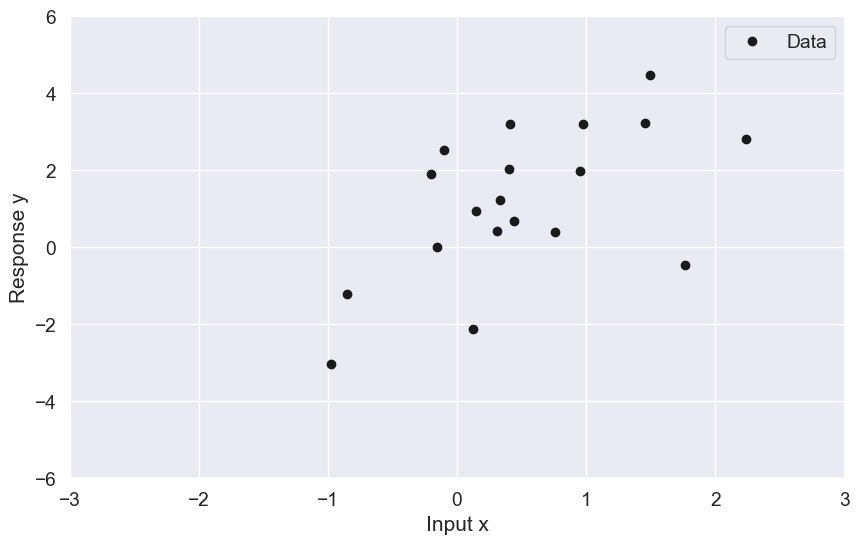

In [2]:
# Number of training samples
N = 20

# Create training input data as a 1D array and then reshape to a column vector (shape: [20, 1])
# The slicing "[:, None]" adds an extra axis so that xtrain becomes of shape (20,1).
# This is useful for broadcasting operations later on, for example when adding a bias term.
xtrain = jnp.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151, -0.103, 0.411,
                    0.144, 1.454, 0.761, 0.122, 0.444, 0.334, 1.494, -0.205, 0.313, -0.854])[:, None]
print(f"X-train shape {xtrain.shape}")

# Create training output data as a 1D array and reshape to a column vector (shape: [20, 1])
# The "[:, None]" similarly converts the array into a column vector.
ytrain = jnp.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009, 2.513, 3.194,
                    0.935, 3.216, 0.386, -2.118, 0.674, 1.222, 4.481, 1.893, 0.422, -1.209])[:, None]

# Define a function to plot the toy dataset.
def plot_toydata(ax):
    # When plotting, broadcasting allows the function to handle the arrays even if their dimensions
    # are not immediately matching. Here, xtrain (shape: [20,1]) and ytrain (shape: [20,1]) are automatically
    # squeezed to 1D arrays if needed by the plotting function.
    ax.plot(xtrain, ytrain, 'k.', label='Data', markersize=12)
    ax.set(xlabel='Input x', ylabel='Response y', xlim=(-3, 3), ylim=(-6, 6))
    ax.legend()

# Create a matplotlib figure and axes, then plot the toy data.
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_toydata(ax)

The purpose of this part is to understand the basic building blocks of the linear model and reinforce the concepts of prior, likelihood, and posterior. First, we will define a convenient function for evaluating and plotting distributions using densities.

In [3]:
def plot_distribution(ax, x, y, density_fun, color=None, visibility=1, label=None, title=None, num_points = 100):
    # Create grid for parameters (a, b)
    # a: intercept, b: slope
    # a_array shape: (num_points,)
    # b_array shape: (num_points,)
    a_array = jnp.linspace(-4, 4, num_points)
    b_array = jnp.linspace(-4, 4, num_points)
    # A_array, B_array shape: (num_points, num_points)
    A_array, B_array = jnp.meshgrid(a_array, b_array)   
    
    # Form array with all combinations of (a, b) in our grid
    # AB shape: (num_points*num_points, 2)
    AB = jnp.column_stack((A_array.ravel(), B_array.ravel()))
    
    # Evaluate density for every point in the grid and reshape back
    # Z = log density, shape: (num_points*num_points,)
    # density_fun(x, y, a, b) expects a and b as 1D arrays of same length
    Z = density_fun(x, y, A_array.ravel(), B_array.ravel())
    # Reshape Z to (num_points, num_points) for contour plotting
    Z = Z.reshape((len(a_array), len(b_array)))
    
    # Plot contour of exp(Z) to get the density
    # This visualizes the density p(a, b | x, y) for the given distribution
    ax.contour(a_array, b_array, jnp.exp(Z), colors=color, alpha=visibility)
    # Dummy plot for legend
    ax.plot([-1000], [-1000], color=color, label=label)
    # Set axis labels and limits
    # a: intercept, b: slope
    ax.set(
        xlabel='slope (b)',           # b in y = a + bx
        ylabel='intercept (a)',       # a in y = a + bx
        xlim=(-4, 4),
        ylim=(-4, 4),
        title=title
    )
    # 
    # Equations:
    #   - Prior:        p(w) = N(w | 0, α⁻¹ I)
    #   - Likelihood

Then we will implement the prior, likelihood and posterior densities:

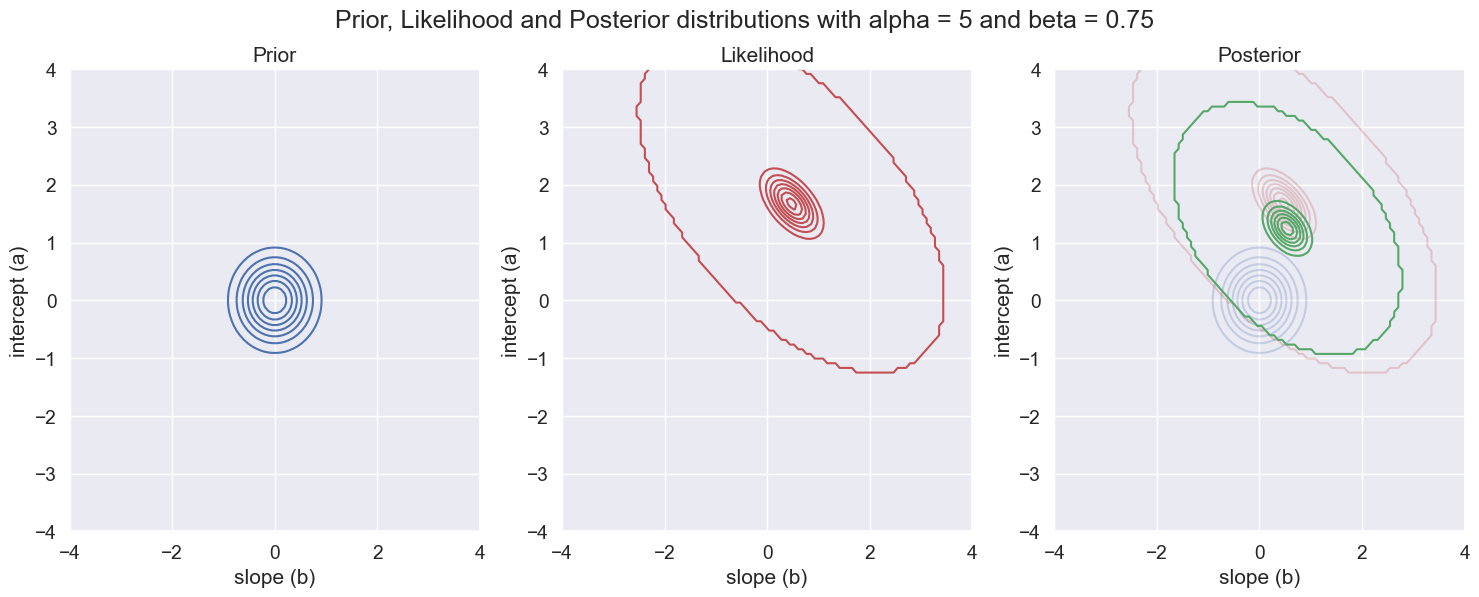

In [5]:
# ------------------------ START SELECTION_PLACEHOLDER ------------------------
# Set hyperparameters:
# A larger alpha means a tighter prior on your parameters (likely around 0)
# A larger beta means less noise in the data so the data are more reliable
alpha = 5      # sigma      # Prior precision: controls the spread (variance = 1/alpha) of the prior distribution over parameters.
beta = 3/4    # tau       # Likelihood precision: controls the noise level (variance = 1/beta) in the observation model.

# Define a lambda function to compute the log probability density of a normal distribution.
# This function computes: log N(x|m, v) = -0.5*log(2*pi*v) - 0.5*((x-m)^2)/v.
# Input shapes: x, m: (...,), v: scalar or (...,)
# Output shape: (...,)
log_npdf = lambda x, m, v: -0.5 * jnp.log(2 * jnp.pi * v) - 0.5 * ((x - m)**2) / v 

# Define a simple linear prediction function:
# Given input x and parameters a (intercept) and b (slope), returns a + b*x.
# Input shapes: x: (N, 1) or (N,), a: scalar, b: scalar
# Output shape: (N, 1) or (N,)
predict = lambda x, a, b: a + b * x

def log_prior(x, y, a, b):
    """
    Computes the log prior probability of the parameters a and b.
    We assume a zero-mean isotropic Gaussian prior over the parameters with covariance 1/alpha * I.
    Equation: log p([a, b]) = log N([a, b] | [0, 0], (1/alpha) * I)
    
    Parameters:
        x, y : Training data (not used here but kept for interface consistency)
        a, b : Parameters (intercept and slope), shape: scalars or arrays of same shape
    
    Returns:
        Log probability of the parameters under the prior.
        Output shape: same as broadcasted shape of a and b
    """
    # jnp.column_stack([a, b]) creates the parameter vector.
    # multivariate_normal.logpdf evaluates the log PDF of a multivariate Gaussian.
    return multivariate_normal.logpdf(jnp.column_stack([a, b]), jnp.array([0, 0]), 1/alpha * jnp.identity(2))

def log_likelihood(x, y, a, b):
    """
    Computes the total log likelihood of the observed data (x, y) given parameters a and b.
    The model predicts y = a + b*x with Gaussian noise of variance 1/beta.
    Equation: sum_i log N(y_i | a + b*x_i, 1/beta)
    
    Parameters:
        x : Input features, shape: (N, 1) or (N,)
        y : Observed outputs, shape: (N, 1) or (N,)
        a, b : Model parameters, scalars
    
    Returns:
        The sum of log likelihoods over all data points.
        Output shape: scalar
    """
    # predict(x, a, b) provides the mean prediction.
    # The variance of the likelihood is 1/beta.
    return jnp.sum(log_npdf(y, predict(x, a, b), 1/beta), 0)

def log_posterior(x, y, a, b):
    """
    Computes the log posterior for parameters a and b given data (x, y) by summing
    the log prior and the log likelihood.
    Equation: log p(a, b | x, y) ∝ log p(a, b) + log p(y | x, a, b)
    
    Parameters:
        x, y : Data.
        a, b : Parameters.
    
    Returns:
        Log posterior value.
        Output shape: same as broadcasted shape of a and b
    """
    return log_prior(x, y, a, b) + log_likelihood(x, y, a, b)

def design_matrix(x):
    """
    Constructs the design matrix for linear regression.
    For input vector x, returns a matrix with a column of ones (for the intercept)
    and a column with the actual x values.
    Equation: X = [1, x]
    
    Parameters:
        x : Input data vector, shape: (N, 1) or (N,)
    
    Returns:
        Design matrix of shape (N, 2)
    """
    return jnp.column_stack((jnp.ones(len(x)), x))

# Create a figure with 3 subplots to visualize the prior, likelihood and posterior distributions.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# set a common title 
fig.suptitle(f'Prior, Likelihood and Posterior distributions with alpha = {alpha} and beta = {beta}')
# Plot prior: shows the belief about parameters before seeing the data.
plot_distribution(axes[0], xtrain, ytrain, density_fun=log_prior, color='b', title='Prior')
# Plot likelihood: shows how likely the observed data are for different parameter settings.
plot_distribution(axes[1], xtrain, ytrain, density_fun=log_likelihood, color='r', title='Likelihood')
# Plot posterior: overlay prior and likelihood (with reduced visibility) and plot the resulting posterior.
plot_distribution(axes[2], xtrain, ytrain, density_fun=log_prior, color='b', visibility=0.25, label='Prior')
plot_distribution(axes[2], xtrain, ytrain, density_fun=log_likelihood, color='r', visibility=0.25, label='Likelihood')
plot_distribution(axes[2], xtrain, ytrain, density_fun=log_posterior, color='g', label='Posterior', title='Posterior')
# ------------------------- END SELECTION_PLACEHOLDER -------------------------


**Task 1.1**: Compute the maximum likelihood solution (MLE), the MAP solution and the posterior mean for the slope and intercept. Plot all three points in the right-most panel above.
_____


**Task 1.2**: Explain the role of $\alpha$ and $\beta$ based on the plots above. What happens if you increase or decrease $\alpha$ or $\beta$?

- Think of $\lambda$ as a dial, which controls how strongly we want to shrink/regularize the parameter vector $w$ toward zero. 
- In Bayesian machinery, the $\lambda$ comes from having Gaussian prior on the parameters. 




1) $\lambda \to 0$
- This means, that $\alpha$ is small OR $\beta$ is large 
- Either there is a very **weak prior** (allowing large parameter values) or the data is trusted **very strongly -> (low noise)**
- **RESULT**: The MAP solution $w_{MAP}$ get closer to MLE (OLS) solution. The posterior becomes dominated by the likelihood. 

2) $\lambda \approx 1$
- Means **prior precision $\alpha$ or $\sigma$ is about the same as data precission $\beta$ or $\tau$
- **Interpretation** Prior and the data likelihood are weighted equally. 
- **RESULT**: The MAP solution is somewhere between the pure MLE and the pure prior guess (0,0).

3) $\lambda \to \infty$
- Means $\alpha$ is huge or $\beta$ is tiny
- **Interpretation**: The prior strongly dominates the posterior or the data is trusted very little (very noisy data $\beta approx 0$)
- **RESULT** MAP solution gets pulled heavily toward (0,0). The posterior mass is near the priors mode. 
- In the extreme, the data becomes almost irrelevant, and you basically stay at the prior mean. 
____






**Task 1.3**: What happens to the posterior mean and covariance if you let $\beta$ approach zero (this is equivalent to the noise variance going to infinity)? Explain what you see using eq. (1) and (2) above.

**Solution**

From eq. (1) above, we see that the posterior covariance reverts to the prior covariance when $\beta \rightarrow 0$
\begin{align*}
    \lim\limits_{\beta \rightarrow 0}\mathbf{S} =  \lim\limits_{\beta\rightarrow 0}\left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1} =  \left(\mathbf{S}_0^{-1} \right)^{-1} = \mathbf{S}_0
\end{align*}
Similarly, for the posterior mean
\begin{align*}
    \mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{y} = \beta \left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y} = \left(\beta^{-1}\mathbf{S}_0^{-1} + \beta^{-1}\beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y} = \left(\beta^{-1}\mathbf{S}_0^{-1} + \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}
\end{align*}

When $\beta$ approaches 0, $\beta^{-1}$ increases and eventually the term for the prior covariance ($\beta^{-1} \mathbf{S}_0^{-1}$) will dominate the sum in the inverse yielding
\begin{align*}
    \mathbf{m} \approx \left(\beta^{-1}\mathbf{S}_0^{-1}\right)^{-1}\mathbf{\Phi}^T\mathbf{y} = \beta\mathbf{S}_0\mathbf{\Phi}^T\mathbf{y} \rightarrow 0
\end{align*}
Therefore, $\mathbf{m}$ converges to the zero vector, which is the prior mean, as $\beta \rightarrow 0$. Since $\beta$ controls the precision of our observations, it makes intuitive sense that the model become independent of the data when the precision goes to zero (or equivalently, when the noise variance goes to infinity).

**End of solution**




**Task 1.4** Show that when we make the prior distribution infinitely wide, i.e. $\alpha \rightarrow 0$, then the posterior mean converges to the maximum likelihood solution.


*Hints*: 
- Recall: $\mathbf{S}_0 = \alpha^{-1}\mathbf{I}$
- Substitute the expression for the posterior covariance in eq. (1) into the expression for the posterior mean in eq. (2) and take the limit $\alpha \rightarrow 0$.

**Solution**

Substituting eq. (1) into eq. (2) yields
\begin{align*}
    \mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{y} = \beta\left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}
\end{align*}

Next, let's substitute $\mathbf{S}_0 = \alpha^{-1} \mathbf{I}$ into the equation above to get
\begin{align*}
    \mathbf{m} = \beta\left(\alpha \mathbf{I} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}
\end{align*}

Taking the limit $\alpha \rightarrow 0$ yields
\begin{align*}
    \lim\limits_{\alpha \rightarrow 0} \mathbf{m} &= \beta\left(\beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}\\
    %
    &= \beta\beta^{-1}\left(\mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}\\
    %
    &= \left(\mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{y}\\
    %
    &= \hat{\mathbf{w}}_{\text{MLE}}
\end{align*}

and the result follows.

**End of solution**


## Part 2:  Implementing the posterior distribution

In the cell below, you are given an incomplete implementation of Bayesian linear regression. Your task is to complete the implementation. See details below.

In [ ]:
# This class implements Bayesian Linear Regression.
# It computes the posterior distribution over the weights
# given the design matrix (Phi) and the observed targets (y).
class BayesianLinearRegression(object):
    
    def __init__(self, Phi, y, alpha=1., beta=1.):
        # Store the design matrix and output vector. 
        # Phi is the input matrix where each row is an observation and each column is a feature.
        # y is the corresponding vector of outputs/responses.
        # Input shapes:
        #   Phi: (N, D)
        #   y:   (N, 1)
        self.Phi, self.y = Phi, y
        # Determine the number of observations (N) and number of features (D)
        self.N, self.D = Phi.shape
        # Store the hyperparameters:
        # alpha is the precision (inverse variance) of the weight prior.
        # beta is the precision (inverse variance) of the noise in the data.
        self.alpha, self.beta = alpha, beta
        
        # Compute the posterior distribution parameters (mean and covariance) of the weights.
        self.m, self.S = self.compute_posterior(alpha, beta)
        # Also compute the log marginal likelihood of the observed data.
        self.log_marginal_likelihood = self.compute_marginal_likelihood(alpha, beta)

        # Perform sanity checks to ensure dimensions of computed quantities are correct.
        self.check_dimensions()

    def check_dimensions(self):
        # Use D as the number of parameters/weights.
        D = self.D
        # Assert that the shape of y is (N, 1).
        # The message shows the expected shape using the number of data points (N).
        assert self.y.shape == (self.N, 1), f"Wrong shape for data vector y.\n For N = {self.N}, the shape of y must be ({self.N}, 1), but the actual shape is {self.y.shape}"
        # Check the posterior mean has expected dimensions (D, 1)
        assert self.m.shape == (D, 1), f"Wrong shape for posterior mean.\nFor D = {D}, the shape of the posterior mean must be ({D}, 1), but the actual shape is {self.m.shape}"
        # Check that the posterior covariance matrix has dimensions (D, D)
        assert self.S.shape == (D, D), f"Wrong shape for posterior covariance.\nFor D = {D}, the shape of the posterior covariance must be ({D}, {D}), but the actual shape is {self.S.shape}"

    # Function to compute the posterior mean and covariance of the weights.
    # The posterior distribution is a normal distribution N(w|m, S).
    # Input: 
    #   alpha: scalar
    #   beta: scalar
    # Output:
    #   m: (D, 1) posterior mean
    #   S: (D, D) posterior covariance
    # Equations:
    #   S = (alpha * I + beta * Phi^T * Phi)^(-1)
    #   m = beta * S * Phi^T * y
    def compute_posterior(self, alpha, beta):
        """ computes the posterior N(w|m, S) and return m, S.
            Shape of m and S must be (D, 1) and (D, D), respectively  """
        
        S_0 = 1 / alpha * jnp.eye(self.D)  # (D, D)
        S_0_inv = jnp.linalg.inv(S_0)      # (D, D)

        A = S_0_inv + beta * self.Phi.T @ self.Phi  # (D, D)
        S = jnp.linalg.inv(A)                       # (D, D)

        m = (beta *  S) @ self.Phi.T @ self.y       # (D, 1)

        return m, S
      
    # Function to generate samples from the prior distribution over weights.
    # It uses a multivariate normal distribution where the covariance is scaled by 1/alpha.
    # Input:
    #   key: PRNG key
    #   num_samples: int
    # Output:
    #   samples: (num_samples, D)
    def generate_prior_samples(self, key, num_samples):
        """ generate samples from the prior  """
        return random.multivariate_normal(key, jnp.zeros(len(self.m)), (1/self.alpha)*jnp.identity(len(self.m)), shape=(num_samples, ))
    
    # Function to generate samples from the posterior distribution over weights.
    # Input:
    #   key: PRNG key
    #   num_samples: int
    # Output:
    #   samples: (num_samples, D)
    def generate_posterior_samples(self, key, num_samples):
        """ generate samples from the posterior  """
        # Samples are drawn from a multivariate normal with mean m and covariance S.
        # .ravel() is used to convert m into a 1d array.
        return random.multivariate_normal(key, self.m.ravel(), self.S, shape=(num_samples, ))
    
    # Function to compute the predictive distribution (mean and variance) for the latent function f.
    # Given a new design matrix Phi, it computes the mean and variance of the function outputs.
    # Input:
    #   Phi: (N, D)
    # Output:
    #   mu_f: (N,)
    #   var_f: (N,)
    # Equations:
    #   mu_f = Phi @ m
    #   var_f = diag(Phi @ S @ Phi^T)
    def predict_f(self, Phi):
        """ computes posterior mean (mu_f) and variance (var_f) of f(phi(x)) for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_f and var_f must be (N,)
            The function returns (mu_f, var_f)
        """
        # Compute the predictive mean for the latent function.
        mu_f = (Phi @ self.m).ravel()  # (N,)
        # Compute the predictive variance for the latent function.
        var_f = jnp.diag(Phi @ self.S @ Phi.T)  # (N,)

        # Sanity checks to ensure the outputs have the correct shape.
        assert mu_f.shape == (Phi.shape[0],), "Shape of mu_f seems wrong. Check your implementation"
        assert var_f.shape == (Phi.shape[0],), "Shape of var_f seems wrong. Check your implementation"
        return mu_f, var_f
        
    # Function to compute the predictive distribution (mean and variance) for the actual outputs y.
    # It incorporates the noise variance from the likelihood.
    # Input:
    #   Phi: (N, D)
    # Output:
    #   mu_y: (N,)
    #   var_y: (N,)
    # Equations:
    #   mu_y = mu_f
    #   var_y = var_f + 1/beta
    def predict_y(self, Phi):
        """ returns posterior predictive mean (mu_y) and variance (var_y) of y = f(phi(x)) + e for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_y and var_y must be (N,).
            The function returns (mu_y, var_y)
        """
        # Get the predictive mean and variance for the latent function f.
        mu_f, var_f = self.predict_f(Phi)
        # Compute the mean for the observed output y.
        mu_y = mu_f
        # Compute the variance for y; note that the noise variance (1/beta) needs to be added.
        var_y = var_f + 1 / self.beta

        # Verify that the computed predictions have the correct dimensions.
        assert mu_y.shape == (Phi.shape[0],), "Shape of mu_y seems wrong. Check your implementation"
        assert var_y.shape == (Phi.shape[0],), "Shape of var_y seems wrong. Check your implementation"
        return mu_y, var_y
        
    # Function to compute the log marginal likelihood of the data.
    # This value can be used for model selection and hyperparameter tuning.
    # The implementation is based on equations from Bishop's book.
    # Input:
    #   alpha: scalar
    #   beta: scalar
    # Output:
    #   log marginal likelihood: scalar
    # Equation: See Bishop eq. 3.86
    def compute_marginal_likelihood(self, alpha, beta):
        """ computes and returns log marginal likelihood p(y|alpha, beta) """
        # Prior precision matrix (diagonal matrix with alpha on the diagonal)
        inv_S0 = alpha*jnp.identity(self.D)
        # Compute the posterior precision matrix A using the design matrix.
        A = inv_S0 + beta*(self.Phi.T@self.Phi)
        # Compute the posterior mean using a linear system solve for numerical stability.
        m = beta*jnp.linalg.solve(A, self.Phi.T)@self.y   # (eq. 3.53 in Bishop)
        # Compute the posterior covariance matrix as the inverse of A.
        S = jnp.linalg.inv(A)                             # (eq. 3.54 in Bishop)
        # Compute the energy term which combines the residual error and the prior.
        Em = beta/2*jnp.sum((self.y - self.Phi@m)**2) + alpha/2*jnp.sum(m**2)
        # Compute the log marginal likelihood using determinants and constants.
        return self.D/2*jnp.log(alpha) + self.N/2*jnp.log(beta) - Em - 0.5*jnp.linalg.slogdet(A)[1] - self.N/2*jnp.log(2*jnp.pi)
         
    # Function to optimize the hyperparameters (alpha and beta) by maximizing the marginal likelihood.
    def optimize_hyperparameters(self):
        # Initialize the parameters in the log domain for better stability during optimization.
        theta0 = jnp.array((jnp.log(self.alpha), jnp.log(self.beta)))
        # Define the negative marginal likelihood function and its gradient.
        def negative_marginal_likelihood(theta):
            # Convert back to the original scale using exponentiation.
            alpha, beta = jnp.exp(theta[0]), jnp.exp(theta[1])
            return -self.compute_marginal_likelihood(alpha, beta)

        # Optimize the negative marginal likelihood using a gradient-based optimizer.
        result = minimize(value_and_grad(negative_marginal_likelihood), theta0, jac=True)

        # Store the optimized hyperparameters and update the posterior distribution.
        theta_opt = result.x
        self.alpha, self.beta = jnp.exp(theta_opt[0]), jnp.exp(theta_opt[1])
        self.m, self.S = self.compute_posterior(self.alpha, self.beta)
        self.log_marginal_likelihood = self.compute_marginal_likelihood(self.alpha, self.beta)

# Sanity check of implementation.
# Here, we use a toy example with a 2x2 design matrix and 2x1 responses.
# The assertions verify that the computed posterior mean and covariance are correct.
model = BayesianLinearRegression(0.5*jnp.ones((2,2)), 2*jnp.ones((2, 1)), alpha=0.5, beta=0.5)       
assert jnp.allclose(model.m, jnp.array([1, 1])), "Something seems to be wrong with your implementation of the posterior mean. Please check your implementation." 
assert jnp.allclose(model.S, jnp.array([[1.5, -0.5], [-0.5, 1.5]])), "Something seems to be wrong with your implementation of the posterior covariance. Please check your implementation." 

# Fit model to the training toy dataset.
# 'design_matrix' is a function (or variable) defined elsewhere that creates the design matrix.
Phi_train = design_matrix(xtrain)
model = BayesianLinearRegression(Phi_train, ytrain)

print(f"Phi shape: {Phi_train.shape}")
print("Phi: ", Phi_train)


Phi shape: (20, 2)
Phi:  [[ 1.     1.764]
 [ 1.     0.4  ]
 [ 1.     0.979]
 [ 1.     2.241]
 [ 1.     1.868]
 [ 1.    -0.977]
 [ 1.     0.95 ]
 [ 1.    -0.151]
 [ 1.    -0.103]
 [ 1.     0.411]
 [ 1.     0.144]
 [ 1.     1.454]
 [ 1.     0.761]
 [ 1.     0.122]
 [ 1.     0.444]
 [ 1.     0.334]
 [ 1.     1.494]
 [ 1.    -0.205]
 [ 1.     0.313]
 [ 1.    -0.854]]


**Task 2.1**: Complete the implementation of the function *compute_posterior* above using eq. (1) and (2).




**Task 2.2**: Report the posterior mean and a 95\% credibility interval for the intercept and slope for $\alpha=\beta=1$. Compare your estimate to the plot of the data above. Do the results look reasonable compared to the plots above?

*Hint: There are several ways to approach this. E.g. for a Gaussian random variable $\mathcal{N}(\mu, \sigma^2)$, the interval $\left[\mu - 1.96\sigma, \mu + 1.96\sigma\right]$ contains approximately 95\% of its probability mass.*


In [11]:
##############################################
# Your solution goes here
##############################################

# The following code computes the posterior mean and covariance for the Bayesian linear regression model.
# It uses the fitted model object 'model', which is an instance of BayesianLinearRegression.
# The posterior mean and covariance are computed using equations:
#   Posterior covariance: S = (S0^{-1} + beta * Phi^T * Phi)^{-1}   [Eq. (1)]
#   Posterior mean:      m = beta * S * Phi^T * y                   [Eq. (2)]
# Input shapes:
#   model.m: (D, 1)  (posterior mean, D = number of features)
#   model.S: (D, D)  (posterior covariance)
# Output:
#   posterior_mean: (D,)      (flattened mean vector)
#   posterior_covariance: (D, D)
#   std_dev: (D,)             (standard deviations for each parameter)
#   95% credibility intervals for each parameter

posterior_mean = model.m.ravel()  # shape: (2,)
posterior_covariance = model.S    # shape: (2, 2)

print(f"Posterior Covariance {posterior_covariance}")
print(f"Posterior mean {posterior_mean}")

# Extract diagonal elements (variances) from the covariance matrix
print(f"Diagonals from the Covariance Matrix {jnp.diag(posterior_covariance)}")

# Compute standard deviations for each parameter (sqrt of variances)
std_dev = jnp.sqrt(jnp.diag(posterior_covariance))  # shape: (2,)

# Compute 95% credibility intervals for each parameter (mean ± 1.95*std)
lower_intercept, lower_slope = posterior_mean - 1.95 * std_dev
upper_intercept, upper_slope = posterior_mean + 1.95 * std_dev

print(f"Lower intercept: {lower_intercept}, Lower slope: {lower_slope}")
print(f"Upper intercept: {upper_intercept}, Upper slope: {upper_slope}")

##############################################
# End of solution
##############################################

Posterior Covariance [[ 0.06627796 -0.03440488]
 [-0.03440488  0.06343863]]
Posterior mean [0.5061498 1.5832696]
Diagonals from the Covariance Matrix [0.06627796 0.06343863]
Lower intercept: 0.004131913185119629, Lower slope: 1.0921225547790527
Upper intercept: 1.0081677436828613, Upper slope: 2.0744166374206543


### Part 3:  The posterior predictive distribution

Next, we will use our toy dataset from above to study the relationship between the posterior distribution $p(\mathbf{w}|\mathbf{y})$ and the posterior predictive distribution $p(y^*|\mathbf{x}^*, \mathbf{y})$.
After we obtained the posterior distribution $p(\mathbf{w}|\mathbf{y}) = \mathcal{N}(\mathbf{w}| \mathbf{m}, \mathbf{S})$, we can also compute the distributions of $f_* = f(\mathbf{x}_*) = \phi(x_*)^T \mathbf{w}$ and $y_* = f(\mathbf{x}_*) + e$ for any new data point $\mathbf{x}_*$:

$$\begin{align*}
p(f_*|\mathbf{y}, \mathbf{x}_*) &=  \mathcal{N}(f_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_*)\\
p(y_*|\mathbf{y}, \mathbf{x}_*) &=  \mathcal{N}(y_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_* + \beta^{-1}).
\end{align*}$$

We often refer to the former as the **posterior distribution of $f_*$** and to latter as the **posterior predictive distribution for $y_*$**. Before studying the relationship, let's implement the two distributions.



**Task 3.1**: Go back up to the implementation of the class *BayesianLinearRegression* and complete the implementation of the functions *predict_f* and *predict_y*. These functions compute and return the mean and variance of $p(f_*|\mathbf{x}_*, \mathbf{y})$ and $p(y_*|\mathbf{x}_*, \mathbf{y})$, respectively, for a design matrix of new input points.

*Hints: The cell below will do a simple sanity check of your implementation. Passing the sanity check does not guarantee that your implementation is correct, though*


In [7]:
# sanity check to help verify implementation
dummy_model = BayesianLinearRegression(jnp.ones((2,2)), jnp.ones((2, 1)), 1, 1)
dummy_mu_f, dummy_var_f = dummy_model.predict_f(jnp.ones((1,2)))
dummy_mu_y, dummy_var_y = dummy_model.predict_y(jnp.ones((1,2)))

assert jnp.allclose(dummy_mu_f, jnp.array([0.8])), "Posterior mean of f_* seems wrong. Please check your implementation"
assert jnp.allclose(dummy_var_f, jnp.array([0.4])), "Posterior variance of f_* seems wrong. Please check your implementation"
assert jnp.allclose(dummy_mu_y, jnp.array([0.8])), "Posterior predictive mean of y_* seems wrong. Please check your implementation"
assert jnp.allclose(dummy_var_y, jnp.array([1.4])), "Posterior predictive variance of y_* seems wrong. Please check your implementation"

Assuming your implementation above is correct, the cell below analyses the data set using $N = \left\lbrace 0, 1, 2, 5, 10, 20 \right\rbrace$, respectively, where the first row shows the results for $N = 0$ and so on and so forth. 


'\nREQUIRED FUNCTIONS AND CLASSES:\n\n1. design_matrix(x):\n   - Input: x, shape (n_points, 1) \n   - Output: Phi, shape (n_points, n_features)\n   - Creates basis functions, e.g., φ(x) = [1, x] for linear model\n\n2. BayesianLinearRegression class:\n   - Constructor: __init__(Phi, y, alpha, beta)\n     * Phi: design matrix, shape (n_samples, n_features)\n     * y: targets, shape (n_samples, 1)\n     * alpha: prior precision (scalar)\n     * beta: noise precision (scalar)\n   \n   - Methods:\n     * generate_posterior_samples(key, num_samples)\n       Returns: samples from p(w|y), shape (num_samples, n_features)\n     \n     * predict_f(Phi_test)\n       Returns: (mu_f, var_f), both shape (n_test, 1)\n       Predictive distribution for function values\n     \n     * predict_y(Phi_test) \n       Returns: (mu_y, var_y), both shape (n_test, 1)\n       Predictive distribution for observations (includes noise)\n\n3. predict(x, a, b):\n   - Input: x (n_points, 1), a (scalar), b (scalar)\n   

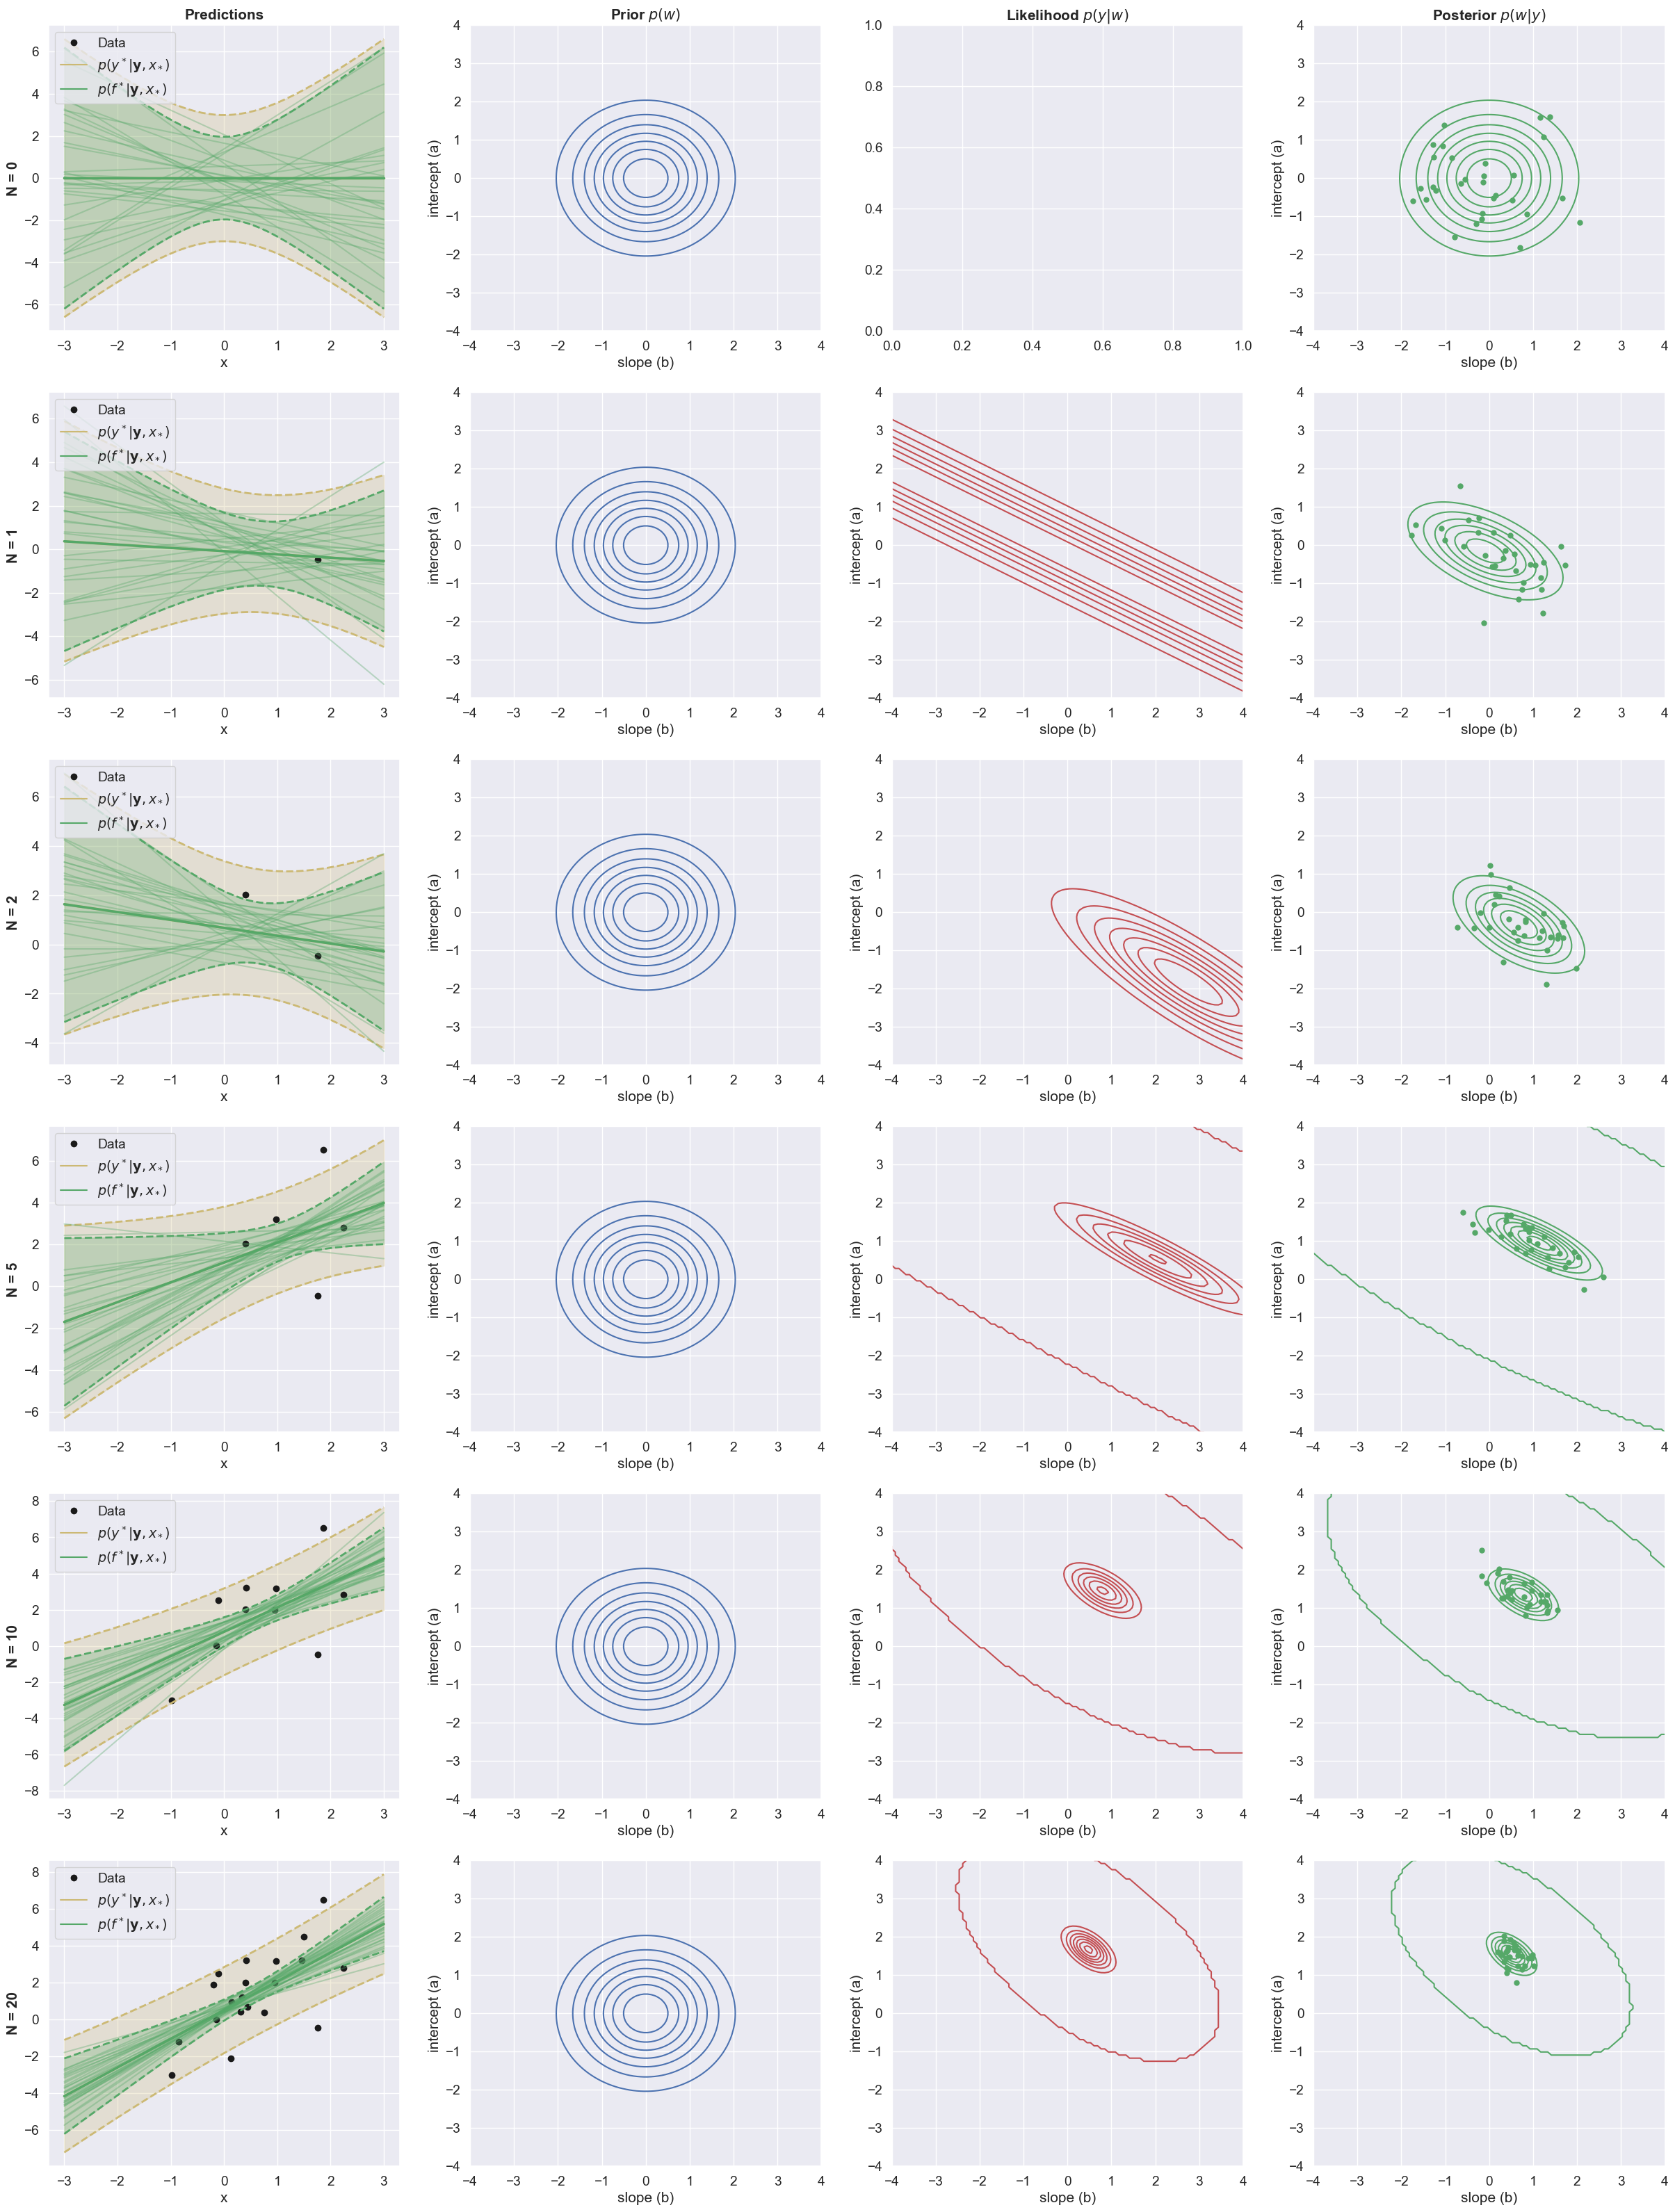

In [16]:
# Helper function for visualizing predictions with confidence intervals
def plot_predictions(ax, x, mu, var, color='r', visibility=0.5, label=None):
    """
    Plot predictions with mean and 95% confidence intervals
    
    Args:
        ax: Matplotlib axis object
        x: Input points, shape (n_points, 1)
        mu: Mean predictions, shape (n_points, 1)
        var: Variance of predictions, shape (n_points, 1)
        color: Color for the plot
        visibility: Alpha value for confidence interval filling
        label: Label for the plot
        
    The confidence interval is computed as:
    CI = μ ± 1.96 * σ, where σ = √var
    This gives approximately 95% confidence interval under Gaussian assumption
    """
    # Compute lower and upper bounds of 95% confidence interval
    # Formula: [μ - 1.96σ, μ + 1.96σ]
    lower, upper = mu - 1.96*jnp.sqrt(var), mu + 1.96*jnp.sqrt(var)
    
    # Plot mean prediction line
    ax.plot(x, mu, color=color, label=label)
    
    # Plot confidence interval boundaries as dashed lines
    ax.plot(x, lower, color=color, linewidth=2, linestyle='--')
    ax.plot(x, upper, color=color, linewidth=2, linestyle='--')
    
    # Fill area between confidence intervals
    ax.fill_between(x.ravel(), lower.ravel(), upper.ravel(), color=color, alpha=visibility)
    
    # Redraw mean line with thicker line for emphasis
    ax.plot(x, mu, '-', color=color, label="", linewidth=2.5)

# Fix random seed for reproducibility
seed = 123
key = random.PRNGKey(seed)

# Hyperparameters for Bayesian Linear Regression
# Prior precision (inverse variance) for weights: p(w) = N(0, α^(-1)I)
alpha = 1.  
# Noise precision (inverse variance) for observations: p(y|x,w) = N(w^T φ(x), β^(-1))
beta = 3/4

# Number of posterior samples to visualize
num_samples = 30

# Create prediction points for visualization
# Shape: (50, 1) - 50 evenly spaced points from -3 to 3
xpred = jnp.linspace(-3, 3, 50)[:, None]

# Design matrices (basis functions) for training and prediction points
# Assumes design_matrix function creates features φ(x) for linear regression
# Shapes: Phi_train: (n_train, n_features), Phi_pred: (50, n_features)
Phi_train = design_matrix(xtrain)
Phi_pred = design_matrix(xpred)

# Create visualization grid: 6 rows (different n values) x 4 columns (different plots)
fig, axes = plt.subplots(6, 4, figsize=(30, 40))

# Iterate through different numbers of training points
for idx_n, n in enumerate([0, 1, 2, 5, 10, 20]):
    # Split random key for sampling
    key, sample_key = random.split(key)
    
    # Compute posterior distribution of regression weights
    # Using first n training points
    # Posterior: p(w|y) ∝ p(y|w)p(w)
    # For linear regression with Gaussian prior and likelihood:
    # p(w|y) = N(w|m_n, S_n)
    # where:
    # S_n = (αI + βΦ^T Φ)^(-1) (posterior covariance)
    # m_n = βS_n Φ^T y (posterior mean)
    model = BayesianLinearRegression(Phi_train[:n, :], ytrain[:n, :], alpha, beta)
    
    # Generate samples from posterior distribution
    # Shape: (num_samples, n_features)
    w_samples = model.generate_posterior_samples(sample_key, num_samples=num_samples)
    
    # Split weight samples into intercept (a) and slope (b) components
    # Assumes 2D feature space with φ(x) = [1, x]
    # Shapes: a_samples: (num_samples,), b_samples: (num_samples,)
    a_samples, b_samples = w_samples[:, 0], w_samples[:, 1]
    
    # Compute posterior predictive distributions
    # For function values f* and observations y*
    # p(f*|y) = N(f*|μ_f, σ²_f)
    # p(y*|y) = N(y*|μ_y, σ²_y)
    # where:
    # μ_f = m_n^T φ(x*) (mean function value)
    # σ²_f = φ(x*)^T S_n φ(x*) (function variance)
    # μ_y = μ_f (mean observation)
    # σ²_y = σ²_f + β^(-1) (observation variance includes noise)
    mu_f, var_f = model.predict_f(Phi_pred)  # Shape: (50, 1), (50, 1)
    mu_y, var_y = model.predict_y(Phi_pred)  # Shape: (50, 1), (50, 1)
    
    # Plot in data space (leftmost column)
    # Show training data points
    axes[idx_n, 0].plot(xtrain[:n, :], ytrain[:n, :], 'k.', markersize=12, label='Data')
    
    # Plot predictive distributions for observations (includes noise)
    plot_predictions(axes[idx_n, 0], xpred, mu_y, var_y, visibility=0.25, 
                    color='y', label='$p(y^*|\\mathbf{y}, x_*)$')
    
    # Plot predictive distributions for function values (noise-free)
    plot_predictions(axes[idx_n, 0], xpred, mu_f, var_f, visibility=0.25, 
                    color='g', label='$p(f^*|\\mathbf{y}, x_*)$')
    
    # Set row label with number of data points
    axes[idx_n, 0].set_ylabel('N = %d' % n, fontweight='bold')
    
    # Plot individual posterior samples as functions f(x) = a + bx
    for i, (ai, bi) in enumerate(zip(a_samples, b_samples)):
        axes[idx_n, 0].plot(xpred, predict(xpred, ai, bi), 'g-', alpha=0.35)
    
    axes[idx_n, 0].legend(loc='upper left')
    axes[idx_n, 0].set(xlabel='x')
    
    # Plot prior distribution p(w) = N(0, α^(-1)I) (second column)
    # log p(w) = -0.5 * α * w^T w + const
    plot_distribution(axes[idx_n, 1], xtrain[:n, :], ytrain[:n, :], 
                     density_fun=log_prior, color='b')
    
    # Plot likelihood p(y|w) (third column, only if we have data)
    # log p(y|w) = -0.5 * β * Σ(y_i - w^T φ(x_i))² + const
    if n > 0:
        plot_distribution(axes[idx_n, 2], xtrain[:n, :], ytrain[:n, :], 
                         density_fun=log_likelihood, color='r')
    
    # Plot posterior distribution p(w|y) ∝ p(y|w)p(w) (fourth column)
    # log p(w|y) = log p(y|w) + log p(w) - log p(y)
    plot_distribution(axes[idx_n, 3], xtrain[:n, :], ytrain[:n, :], 
                     density_fun=log_posterior, color='g')
    
    # Overlay posterior samples on the distribution
    axes[idx_n, 3].plot(a_samples, b_samples, 'g.', markersize=10)

# Set column titles
axes[0, 0].set_title('Predictions', fontweight='bold')
axes[0, 1].set_title('Prior $p(w)$', fontweight='bold')
axes[0, 2].set_title('Likelihood $p(y|w)$', fontweight='bold')
axes[0, 3].set_title('Posterior $p(w|y)$', fontweight='bold')

"""
REQUIRED FUNCTIONS AND CLASSES:

1. design_matrix(x):
   - Input: x, shape (n_points, 1) 
   - Output: Phi, shape (n_points, n_features)
   - Creates basis functions, e.g., φ(x) = [1, x] for linear model

2. BayesianLinearRegression class:
   - Constructor: __init__(Phi, y, alpha, beta)
     * Phi: design matrix, shape (n_samples, n_features)
     * y: targets, shape (n_samples, 1)
     * alpha: prior precision (scalar)
     * beta: noise precision (scalar)
   
   - Methods:
     * generate_posterior_samples(key, num_samples)
       Returns: samples from p(w|y), shape (num_samples, n_features)
     
     * predict_f(Phi_test)
       Returns: (mu_f, var_f), both shape (n_test, 1)
       Predictive distribution for function values
     
     * predict_y(Phi_test) 
       Returns: (mu_y, var_y), both shape (n_test, 1)
       Predictive distribution for observations (includes noise)

3. predict(x, a, b):
   - Input: x (n_points, 1), a (scalar), b (scalar)
   - Output: predictions, shape (n_points, 1)
   - Computes linear function: f(x) = a + bx

4. plot_distribution(ax, x, y, density_fun, color):
   - Visualizes 2D probability density function
   - density_fun: function that computes log probability

5. log_prior, log_likelihood, log_posterior:
   - Functions that compute log probabilities for visualization

MATHEMATICAL BACKGROUND:

1. Prior: p(w) = N(w|0, α^(-1)I)
2. Likelihood: p(y|X,w) = N(y|Φw, β^(-1)I)
3. Posterior: p(w|y) = N(w|m_n, S_n)
   where:
   - S_n = (αI + βΦ^T Φ)^(-1)
   - m_n = βS_n Φ^T y

4. Predictions:
   - p(f*|y) = N(f*|φ(x*)^T m_n, φ(x*)^T S_n φ(x*))
   - p(y*|y) = N(y*|φ(x*)^T m_n, φ(x*)^T S_n φ(x*) + β^(-1))

HOW TO USE:

1. Prepare your data:
   - xtrain: training inputs, shape (n_train, 1)
   - ytrain: training targets, shape (n_train, 1)

2. Define the required functions:
   - design_matrix: to create feature representations
   - predict: for linear predictions
   - plot_distribution: for 2D density visualization
   - log_prior, log_likelihood, log_posterior: for probability computations

3. Implement BayesianLinearRegression class with required methods

4. Run the visualization code to see how predictions change with data

The visualization shows:
- Column 1: Predictions with confidence intervals and posterior samples
- Column 2: Prior distribution over weights
- Column 3: Likelihood function (data fit)
- Column 4: Posterior distribution over weights

Each row shows results for different amounts of training data (0, 1, 2, 5, 10, 20 points).
"""

In the figure above, the first column shows the data as well as the predictive distribution with 95% intervals. Each of the green lines corresponds to the function $f(x)$ for different posterior samples for $\mathbf{w}$. The columns 2, 3, and 4 show the prior, likelihood and posterior, respectively. Study the code and the plots above and answer the following questions:

**Task 3.2**: What happens to prior, likelihood and posterior as the number of samples $N$ increases? [**Discussion question**]
# Effect of Sample Size N on Prior, Likelihood, and Posterior

## 1. Prior Distribution p(w)

**Key observation:** The prior remains **unchanged** as N increases.

- Mathematical form: $p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I})$
- The prior is **data-independent** - it represents our beliefs before seeing any data
- Shape and location stay constant regardless of sample size
- Influence on the posterior **decreases relatively** as more data is observed

## 2. Likelihood Function p(y|w)

**Key observation:** The likelihood becomes **more concentrated/peaked** as N increases.

- Mathematical form: $p(\mathbf{y}|\mathbf{w}) = \prod_{i=1}^{N} \mathcal{N}(y_i|\mathbf{w}^T\boldsymbol{\phi}(\mathbf{x}_i), \beta^{-1})$
- As N increases:
  - More data points constrain the parameter space
  - The likelihood becomes **narrower** and **taller**
  - Peak becomes more pronounced around the maximum likelihood estimate (MLE)
  - Product of more terms makes it more sensitive to parameter deviations
  - In log-space: $\log p(\mathbf{y}|\mathbf{w}) = -\frac{\beta}{2}\sum_{i=1}^{N}(y_i - \mathbf{w}^T\boldsymbol{\phi}(\mathbf{x}_i))^2 + \text{const}$
  - The sum of squared errors accumulates, making the likelihood more peaked

## 3. Posterior Distribution p(w|y)

**Key observation:** The posterior becomes **more concentrated** and **data-dominated** as N increases.

- Mathematical form: $p(\mathbf{w}|\mathbf{y}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)$
- Posterior parameters:
  - Covariance: $\mathbf{S}_N = (\alpha\mathbf{I} + \beta\mathbf{\Phi}^T\mathbf{\Phi})^{-1}$
  - Mean: $\mathbf{m}_N = \beta\mathbf{S}_N\mathbf{\Phi}^T\mathbf{y}$

### As N → ∞:

1. **Variance decreases**: $\mathbf{S}_N \rightarrow \mathbf{0}$ as $\mathbf{\Phi}^T\mathbf{\Phi}$ grows with N
   - Uncertainty about parameters reduces
   - Confidence intervals become narrower

2. **Prior influence diminishes**: The term $\alpha\mathbf{I}$ becomes negligible compared to $\beta\mathbf{\Phi}^T\mathbf{\Phi}$
   - Posterior becomes dominated by the likelihood
   - Initial beliefs matter less with abundant data

3. **Convergence to MLE**: $\mathbf{m}_N \rightarrow \hat{\mathbf{w}}_{\text{MLE}}$
   - Posterior mean approaches the maximum likelihood estimate
   - Bayesian and frequentist estimates converge

4. **Shape evolution**:
   - N = 0: Posterior = Prior (no data influence)
   - Small N: Balance between prior and likelihood
   - Large N: Likelihood dominates, prior influence minimal

## Visual Summary

| N | Prior | Likelihood | Posterior |
|---|-------|------------|-----------|
| 0 | Fixed shape | No data | = Prior |
| Small | Fixed shape | Broad, weak constraints | Balance of prior & data |
| Large | Fixed shape | Narrow, strong peak | ≈ Likelihood shape |
| ∞ | Fixed shape | Delta function at MLE | Delta function at MLE |

## Practical Implications

1. **Early stages** (small N): Prior beliefs significantly influence predictions
2. **Later stages** (large N): Data overwhelms prior, predictions become data-driven
3. **Uncertainty quantification**: Prediction intervals shrink with more data
4. **Computational consideration**: With large N, the posterior becomes approximately Gaussian around the MLE

___________

**Task 3.3**: What happens to the predictions if you keep $\beta = \frac{3}{4}$ and increase $\alpha$, e.g. to $\alpha = 100$ or $\alpha = 1000$? Why?

# Effect of Increasing Prior Precision α on Predictions

## Mathematical Analysis

When we increase α while keeping β = 3/4 fixed, we're making the prior **more concentrated** around zero.

### Prior Distribution
- Prior: $p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I})$
- As $\alpha \uparrow$, prior variance $\alpha^{-1} \downarrow$
- The prior becomes a **tighter** distribution around $\mathbf{w} = \mathbf{0}$

### Posterior Parameters
The posterior covariance and mean are:
- $\mathbf{S}_N = (\alpha\mathbf{I} + \beta\mathbf{\Phi}^T\mathbf{\Phi})^{-1}$
- $\mathbf{m}_N = \beta\mathbf{S}_N\mathbf{\Phi}^T\mathbf{y}$

As $\alpha$ increases:
1. The term $\alpha\mathbf{I}$ dominates in $\mathbf{S}_N$
2. $\mathbf{S}_N \approx \alpha^{-1}\mathbf{I}$ (becomes very small)
3. $\mathbf{m}_N \approx \beta\alpha^{-1}\mathbf{\Phi}^T\mathbf{y}$ (shrinks toward zero)

## Effect on Predictions

### Predictive Mean
- Mean prediction: $\mathbb{E}[f_*] = \boldsymbol{\phi}(\mathbf{x}_*)^T\mathbf{m}_N$
- As $\alpha \rightarrow \infty$: $\mathbf{m}_N \rightarrow \mathbf{0}$
- Therefore: $\mathbb{E}[f_*] \rightarrow 0$

### Predictive Variance
- Function variance: $\mathbb{V}[f_*] = \boldsymbol{\phi}(\mathbf{x}_*)^T\mathbf{S}_N\boldsymbol{\phi}(\mathbf{x}_*)$
- As $\alpha \rightarrow \infty$: $\mathbf{S}_N \rightarrow \mathbf{0}$
- Therefore: $\mathbb{V}[f_*] \rightarrow 0$

## Visual and Practical Effects

### With α = 1 (original):
- Predictions fit the data reasonably well
- Balance between prior and likelihood
- Moderate regularization

### With α = 100:
- Predictions become **flatter** (closer to horizontal)
- Strong regularization effect
- Weights are heavily constrained near zero
- Model underfits the data

### With α = 1000:
- Predictions are **almost flat** (nearly horizontal line at y=0)
- Extreme regularization
- Prior completely dominates the likelihood
- Model essentially ignores the data

## Why This Happens

1. **Strong Prior Belief**: High α represents a very strong belief that weights should be near zero
2. **Regularization**: This acts as L2 (ridge) regularization with penalty $\frac{\alpha}{2}\|\mathbf{w}\|^2$
3. **Prior-Likelihood Balance**: 
   - Small α: Data dominates (flexible fit)
   - Large α: Prior dominates (rigid, constrained fit)
4. **Information Content**: High α means the prior carries more "pseudo-observations" worth of information

## Mathematical Intuition

The posterior precision is:
$$\mathbf{S}_N^{-1} = \alpha\mathbf{I} + \beta\mathbf{\Phi}^T\mathbf{\Phi}$$

- The term $\alpha\mathbf{I}$ represents prior information
- The term $\beta\mathbf{\Phi}^T\mathbf{\Phi}$ represents data information
- When $\alpha \gg \beta\|\mathbf{\Phi}^T\mathbf{\Phi}\|$, prior dominates

## Practical Implications

| α value | Prediction Behavior | Use Case |
|---------|-------------------|----------|
| Small (0.1-1) | Flexible, follows data | When data is reliable |
| Medium (10-100) | Smoothed, regularized | Noisy data, prevent overfitting |
| Large (1000+) | Nearly flat, ignores data | Strong prior knowledge, extreme regularization |

## Code Demonstration

```python
# To see this effect, modify the hyperparameters:
alpha_values = [1, 100, 1000]
beta = 3/4

for alpha in alpha_values:
    # The model will produce increasingly flat predictions
    model = BayesianLinearRegression(Phi_train, ytrain, alpha, beta)
    # Predictions will converge to zero as alpha increases
```

_______________________


**Task 3.4**: Set $\alpha$ to $\alpha = 1$ again. What happens if you decrease $\beta$, e.g. to $\beta = 0.1$? Why?

# Effect of Decreasing Noise Precision β on Predictions

## Mathematical Analysis

When we decrease β from 3/4 to 0.1 while keeping α = 1, we're assuming the observations are **much noisier**.

### Noise Model
- Likelihood: $p(y|f) = \mathcal{N}(y|f, \beta^{-1})$
- Noise variance: $\sigma^2 = \beta^{-1}$
- β = 3/4 → noise variance = 4/3 ≈ 1.33
- β = 0.1 → noise variance = 10 (7.5× larger!)

### Posterior Parameters

The posterior parameters become:
- $\mathbf{S}_N = (\alpha\mathbf{I} + \beta\mathbf{\Phi}^T\mathbf{\Phi})^{-1}$
- $\mathbf{m}_N = \beta\mathbf{S}_N\mathbf{\Phi}^T\mathbf{y}$

As β decreases:
1. The term $\beta\mathbf{\Phi}^T\mathbf{\Phi}$ becomes smaller
2. Prior term $\alpha\mathbf{I}$ becomes relatively more important
3. $\mathbf{S}_N$ increases (more uncertainty about weights)
4. Data has less influence on the posterior

## Effect on Predictions

### 1. Predictive Mean
- Mean function: $\mathbb{E}[f_*] = \boldsymbol{\phi}(\mathbf{x}_*)^T\mathbf{m}_N$
- With smaller β, the posterior mean $\mathbf{m}_N$ is pulled toward the prior mean (zero)
- Predictions become **smoother** and less responsive to individual data points
- The model treats data as unreliable, so it doesn't fit closely

### 2. Predictive Variance

**Function variance:**
- $\mathbb{V}[f_*] = \boldsymbol{\phi}(\mathbf{x}_*)^T\mathbf{S}_N\boldsymbol{\phi}(\mathbf{x}_*)$
- Increases moderately due to larger $\mathbf{S}_N$

**Observation variance:**
- $\mathbb{V}[y_*] = \mathbb{V}[f_*] + \beta^{-1}$
- Increases dramatically due to the $\beta^{-1}$ term
- β = 0.1 adds variance of 10 to every prediction!

## Visual Effects

### With β = 3/4 (original):
- Reasonable fit to data
- Moderate confidence intervals
- Balance between fitting and smoothing

### With β = 0.1:
- **Prediction mean**: Smoother, less fitted to data points
- **Confidence intervals**: Much wider, especially for y*
- **Function samples**: More spread out
- **Overall**: Model assumes data is very noisy, so it "trusts" it less

## Why This Happens

1. **Signal-to-Noise Ratio**: Lower β means worse SNR
   - Model assumes observations are corrupted by large noise
   - Less confidence in each data point

2. **Bayesian Averaging**: With high assumed noise:
   - Each data point provides less information
   - Prior beliefs have relatively more influence
   - Results in conservative, smooth predictions

3. **Regularization Effect**: 
   - Acts similar to assuming noisy measurements
   - Prevents overfitting to potentially noisy data
   - Trade-off: less responsive to genuine patterns

## Mathematical Intuition

The posterior precision can be written as:
$$\mathbf{S}_N^{-1} = \alpha\mathbf{I} + \beta\mathbf{\Phi}^T\mathbf{\Phi}$$

When β is small:
- Data information term $\beta\mathbf{\Phi}^T\mathbf{\Phi}$ is weak
- Prior information $\alpha\mathbf{I}$ dominates
- Effective number of observations is reduced

## Key Differences in Predictions

| Aspect | β = 3/4 | β = 0.1 |
|--------|---------|---------|
| Mean function | Fits data closely | Smooth, ignores details |
| Function uncertainty | Moderate | Larger |
| Observation uncertainty | σ² ≈ 1.33 | σ² = 10 |
| Confidence intervals | Reasonable width | Very wide |
| Response to outliers | Moderate | Minimal |

## Practical Implications

1. **Underfitting**: With β = 0.1, the model will underfit the data
2. **Robustness**: More robust to outliers but may miss true patterns
3. **Uncertainty**: Predictions have much larger error bars
4. **Prior influence**: Prior beliefs become more important

## Visual Comparison

```python
# The key visual differences you'll see:

# Original (β = 3/4):
# - Green bands (function uncertainty) are moderate
# - Yellow bands (observation uncertainty) slightly wider
# - Mean prediction follows data points reasonably well

# Low noise precision (β = 0.1):
# - Green bands become wider
# - Yellow bands become MUCH wider (dominated by β^(-1) = 10)
# - Mean prediction is smoother, less responsive to data
# - Individual posterior samples more spread out
```

______________


**Task 3.5**: The variance of the predictive distribution $p(y_*|\mathbf{y}, \mathbf{x}_*)$ contains two components. Describe the two components in your own words and relate them to epistemic and aleatoric uncertainty. 



# Two Components of Predictive Variance in Bayesian Linear Regression

## The Predictive Distribution

The predictive distribution for new observations is:
$$p(y_*|\mathbf{y}, \mathbf{x}_*) = \mathcal{N}(y_*|\mu_{y_*}, \sigma^2_{y_*})$$

The variance decomposes into two components:
$$\sigma^2_{y_*} = \underbrace{\sigma^2_{f_*}}_{\text{epistemic}} + \underbrace{\beta^{-1}}_{\text{aleatoric}}$$

## Component 1: Function Variance σ²_f* (Epistemic Uncertainty)

### Description
- Represents **uncertainty about the true underlying function**
- Arises from having limited training data
- Calculated as: $\sigma^2_{f_*} = \boldsymbol{\phi}(\mathbf{x}_*)^T\mathbf{S}_N\boldsymbol{\phi}(\mathbf{x}_*)$
- Depends on:
  - Location of test point x*
  - Amount and distribution of training data
  - Prior beliefs (through S_N)

### Key Properties
- **Reducible**: Decreases with more training data
- **Location-dependent**: Higher in regions with sparse data
- **Model uncertainty**: "What is the true function value at this point?"
- Goes to zero as N → ∞ (with sufficient data coverage)

### Intuitive Explanation
This uncertainty exists because we don't know the exact parameters (weights) of our model. Even if we could measure perfectly without noise, we'd still be uncertain about predictions because we're unsure about the true underlying relationship.

## Component 2: Noise Variance β^(-1) (Aleatoric Uncertainty)

### Description
- Represents **inherent randomness in observations**
- The irreducible noise in the measurement process
- Constant across all predictions (homoscedastic assumption)
- Determined by the noise precision parameter β

### Key Properties
- **Irreducible**: Doesn't decrease with more data
- **Location-independent**: Same everywhere
- **Observation noise**: "How much do observations deviate from the true function?"
- Remains constant as N → ∞

### Intuitive Explanation
This uncertainty exists because even if we knew the true function perfectly, individual observations would still vary due to measurement noise, environmental factors, or inherent randomness in the process.

## Visual Interpretation

In the plots from the code:
- **Green bands** (p(f*|y)): Show epistemic uncertainty only
- **Yellow bands** (p(y*|y)): Show total uncertainty (epistemic + aleatoric)
- The difference between yellow and green bands is the aleatoric uncertainty

## Practical Examples

### High Epistemic, Low Aleatoric
- Few training points, precise measurements
- Example: Measuring a physical constant with expensive, accurate equipment
- Prediction: Narrow green bands that widen away from data, slightly wider yellow bands

### Low Epistemic, High Aleatoric
- Many training points, noisy measurements
- Example: Predicting stock prices with abundant historical data
- Prediction: Very narrow green bands, much wider yellow bands

### Mathematical Formulation

For a test point x*:

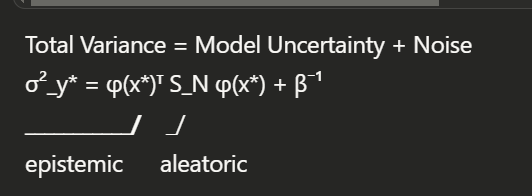

## Why This Decomposition Matters

1. **Decision Making**: 
   - High epistemic → collect more data
   - High aleatoric → improve measurement process or accept inherent variability

2. **Model Evaluation**:
   - Epistemic uncertainty indicates where the model needs more data
   - Aleatoric uncertainty sets the lower bound on prediction error

3. **Active Learning**:
   - Target regions with high epistemic uncertainty for new data collection
   - Recognize when additional data won't help (dominated by aleatoric uncertainty)

## Summary Table

| Aspect | Epistemic (σ²_f*) | Aleatoric (β⁻¹) |
|--------|------------------|-----------------|
| Source | Limited knowledge | Inherent randomness |
| Reducible? | Yes, with more data | No |
| Depends on | Training data, prior, x* | Noise level only |
| Represents | Model uncertainty | Observation noise |
| In practice | "What we don't know" | "What we can't know" |

____________________


**Task 3.6**: As we get more and more data, the variance of the posterior distribution of $\mathbf{w}$ goes to zero. What happens to the variance of $p(y_*|\mathbf{y}, \mathbf{x}_*)$, $p(y^*|\mathbf{x}^*, \mathbf{w})$, and $p(f_*|\mathbf{y}, \mathbf{x}_*)$ as $N$ increases? To answer this, fix $\alpha = \beta = 1$ and consider the point $x^* = 1$. Plot the following three variances: the posterior predictive variance of $y^*$, the conditional variance of $y^*$ given $\mathbf{w}$ and posterior variance of $f^*$ as a function as size of the training set, i.e. for $N = \left\lbrace 0, 1, 2, .., 30 \right\rbrace$. Compare the plots to your findings above.

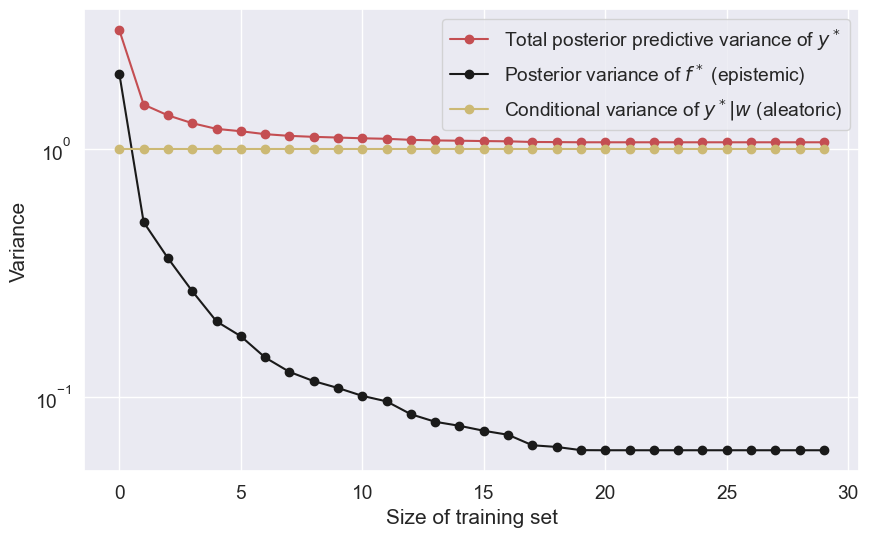

In [18]:
alpha, beta = 1, 1
xstar = 1
Ns = jnp.arange(30)

#########################################################
# For each training set size n in Ns, compute the following:
# - Posterior predictive variance of y* at x* (total uncertainty)
# - Posterior variance of f* at x* (epistemic/model uncertainty)
# - Conditional variance of y* given w (aleatoric/data noise)
#
# Equations:
#   Posterior covariance: S = (alpha * I + beta * Phi^T * Phi)^(-1)
#   Posterior mean:      m = beta * S * Phi^T * y
#   Predictive mean:     mu_f = phi(x*)^T m
#   Predictive variance: var_f = phi(x*)^T S phi(x*)
#   Posterior predictive variance: var_y = var_f + 1/beta
#   Conditional variance: 1/beta
#
# Input shapes:
#   Phi_train: (N, D)
#   ytrain: (N, 1)
#   design_matrix(jnp.array([xstar])): (1, D)
# Output:
#   post_pred_var: list of (1,) arrays (total predictive variance for y*)
#   post_var: list of (1,) arrays (posterior variance for f*)
#   conditional_var: list of scalars (aleatoric variance, always 1/beta)
#########################################################

post_pred_var = []
conditional_var = []
post_var = []
for idx_n, n in enumerate(Ns):
    # Compute posterior of regression weights using first n training points
    model = BayesianLinearRegression(Phi_train[:n, :], ytrain[:n, :], alpha, beta)

    # Compute posterior mean and variance for f* and y* at xstar
    # mu_f, var_f: (1,) - predictive mean and variance for f*
    mu_f, var_f = model.predict_f(design_matrix(jnp.array([xstar])))
    # mu_y, var_y: (1,) - predictive mean and variance for y*
    mu_y, var_y = model.predict_y(design_matrix(jnp.array([xstar])))

    # Save variances for plotting
    post_pred_var.append(var_y)        # Total predictive variance for y*
    conditional_var.append(1/beta)     # Aleatoric variance (noise)
    post_var.append(var_f)             # Posterior variance for f* (epistemic)

# Plot the three variances as a function of training set size
fig, ax = plt.subplots(1, 1, figsize=(10 ,6))
ax.plot(Ns, post_pred_var, 'ro-', label='Total posterior predictive variance of $y^*$')
ax.plot(Ns, post_var, 'ko-', label='Posterior variance of $f^*$ (epistemic)')
ax.plot(Ns, conditional_var, 'yo-', label='Conditional variance of $y^*|w$ (aleatoric)')
ax.set(ylabel='Variance', xlabel='Size of training set')
ax.set_yscale('log')
ax.legend()

#################################################3
# End of solution
#################################################3


**Task 3.7**: Compute the prior mean and variance $f(x^*) = \phi(x^*)^T \bm{w} = a + b x^*$?*. Use the results to explain why the variance of both the posterior distribution of $f(x^*)$ and the variance of the posterior predictive distribution of $y(x^*)$ are smallest for $x^* = 0$ and both increase with $|x^*|$ for $N = 0$.


**Solution**

The prior for $\mathbf{w}$ is $p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I})$ and computing the mean and variance wrt. the prior yields

$$\begin{align*}
\mathbb{E}\left[f(x^*)\right] &= \mathbb{E}\left[\phi(x^*)^T \bm{w}\right] \stackrel{(a)}{=} \phi(x^*)^T \mathbb{E}\left[ \bm{w}\right] \stackrel{(b)}{=} 0,
\end{align*}$$ 

where we used linearity of expectations in step (a) and the fact that $\mathbf{w}$ is zero mean in step (b).

$$\begin{align*}
\mathbb{V}\left[f(x^*)\right] &= \mathbb{V}\left[\phi(x^*)^T \bm{w}\right] = \phi(x^*)^T \mathbb{V}\left[\bm{w}\right]\phi(x^*) \stackrel{(a)}{=} \phi(x^*)^T \alpha^{-1} \bm{I}\phi(x^*) = \alpha^{-1} \phi(x^*)^T \phi(x^*) = \alpha^{-1} \begin{bmatrix} 1 & x^* \end{bmatrix} \begin{bmatrix} 1 \\  x^* \end{bmatrix} = \alpha^{-1} (1 + (x^*)^2), = \alpha^{-1} + \alpha^{-1} (x^*)^2
\end{align*}$$

where we used the fact that the prior covariance of $\mathbf{w}$ is $\alpha^{-1} \mathbf{I}$ in step (a). The calculations above show that the prior mean of $f(x^*)$ is zero for all $x^* \in \mathbb{R}$ and the calculation of variance shows that the variance it a polynomial wrt. $x^*$ with minimum for $x^* = 0$ consistent with the plot above. 

**End of solution**

______

### Part 4:  Modelling the number of Airline passengers

Now we will apply Bayesian linear regression to model the number of monthly airline passengers (in thousands) in the period from 1949-1960. The values $(x_n, y_n)$ denote the time in months since the beginning of 1949 and the number monthly number of passangers, respectively.

So far, we have assumed that the hyperparameters $\alpha$ and $\beta$ of the model were fixed and known, but in practice, we almost always need to estimate them from data (or impose a prior on them and marginalize over them). As long as the number of hyperparameters is small, we can always rely on **cross-validation**. However, often the Bayesian framework offers a way to estimate these parameters based on the training set alone as follows.

The ***evidence approximation*** suggests that we can simply choose the hyperparameters $\alpha, \beta$ that maximizes the marginal likelihood of the model

$$\begin{align*}
\alpha^*, \beta^* = \arg\max\limits_{\alpha, \beta} \ln p(\mathbf{y}|\alpha, \beta),
\end{align*}$$

where $p(\mathbf{y}|\alpha, \beta) = \mathcal{N}(\mathbf{y}|\bm{0}, \alpha^{-1}\Phi^T \Phi + \beta^{-1}\mathbf{I})$ is the marginal likelihood of the model. This is also often referred to as **maximum likelihood type II estimation**. We could also easily "upgrade" this to **MAP type II estimation** by imposing a prior on $p(\alpha, \beta)$, i.e.

$$\begin{align*}
\alpha^*, \beta^* = \arg\max\limits_{\alpha, \beta} \ln p(\mathbf{y}|\alpha, \beta)p(\alpha, \beta).
\end{align*}$$

However, in this exercise we will use a uniform prior on $\alpha$ and $\beta$, i.e. $p(\alpha, \beta) \propto 1$, in which case the two estimators will give the same results.

Note that since both $\alpha >0 $ and $\beta > 0$ are strictly positive parameters (why?), we optimize $\tilde{\alpha} = \log \alpha$ and $\tilde{\beta} = \log \beta$ to enforce positivity on $\alpha$ and $\beta$.
We rely on **JaX** for gradient-based optimization using automatic differentiation and use the standard optimizer in scipy.


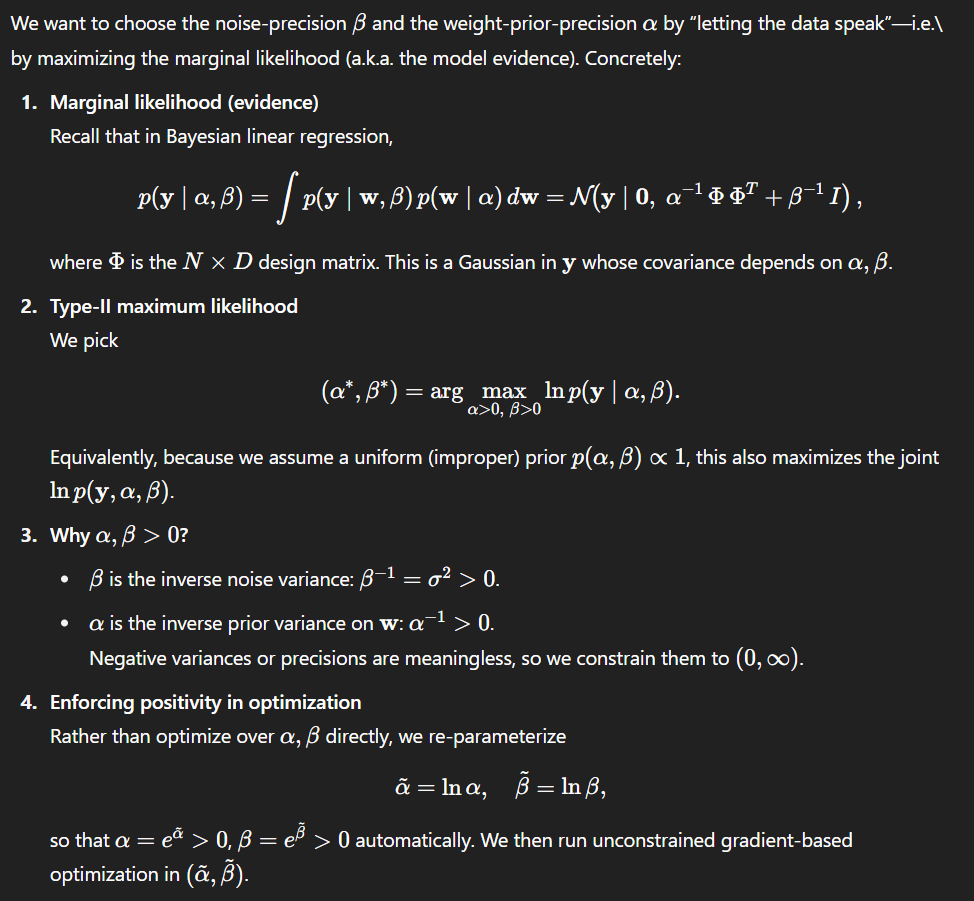
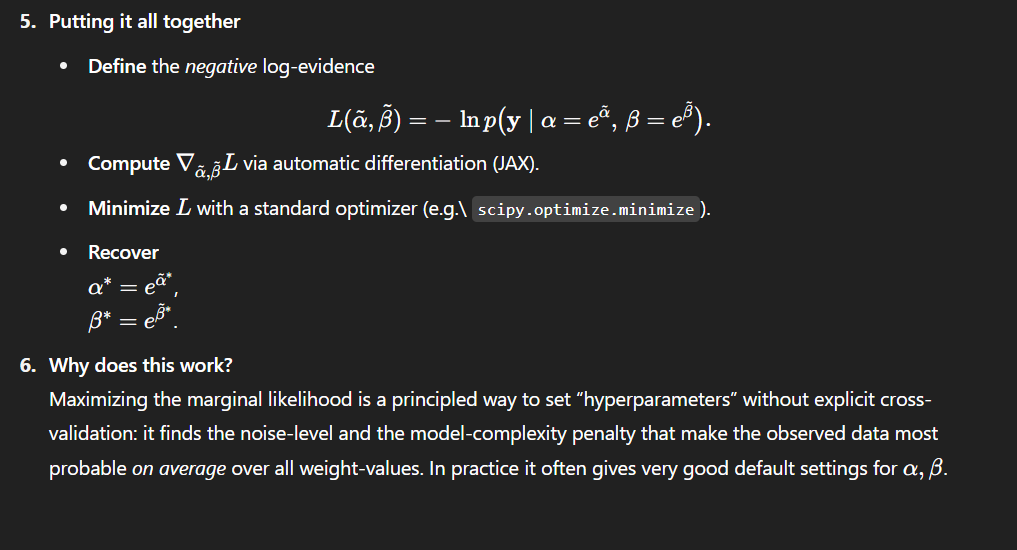

_____________
Let's load the data and plot the data.


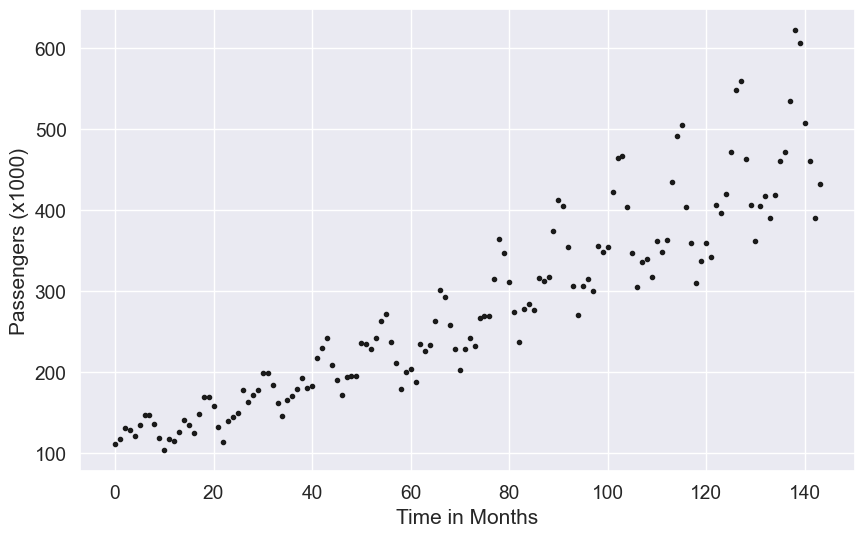

In [20]:
data = pd.read_csv('../AirPassengers.csv')
months = jnp.arange(0, len(data))[:, None]
passengers = jnp.array(data['#Passengers'].values)[:, None]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(months, passengers, 'k.')
ax.set_xlabel('Time in Months')
ax.set_ylabel('Passengers (x1000)');

Since the number of passengers is a strictly positive quantity, we can often get better results by modelling the logarithm of the number of passengers instead.  We also split the dataset into a training and test set

N      = 144
Ntrain = 110
Ntest  = 34


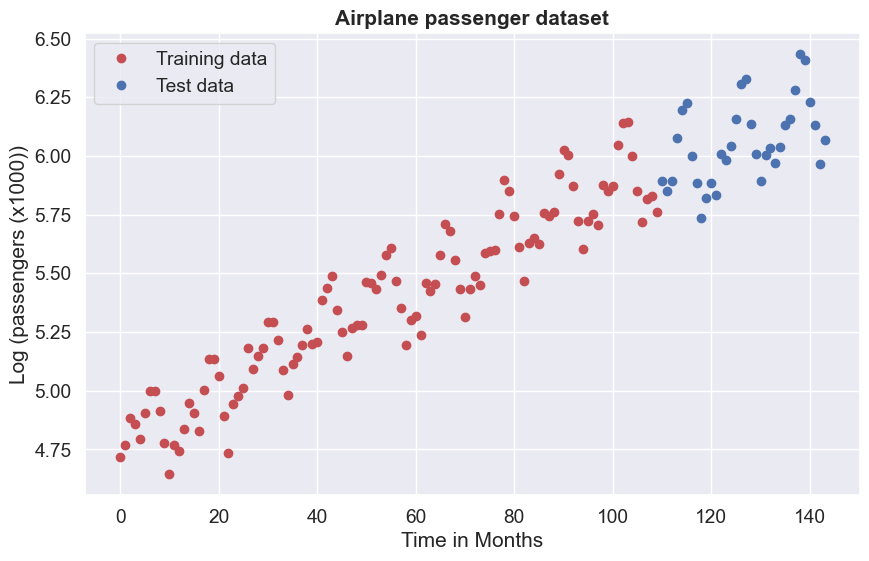

In [21]:
# log transform
# Transform the number of passengers to log scale for better modeling of positive data
# Equation: y = log(passengers)
# Input shape: passengers (N, 1)
# Output shape: y (N, 1)
y = jnp.log(passengers)

# split into training and test sets
# N: total number of data points
N = len(y)
Ntrain = 110  # Number of training samples
Ntest = N - Ntrain  # Number of test samples

# Create input arrays for months (x)
# x: time in months since start, shape (N,)
x = jnp.arange(len(months))

# Split x and y into training and test sets
# xtrain: (Ntrain,), xtest: (Ntest,)
# ytrain: (Ntrain, 1), ytest: (Ntest, 1)
xtrain = x[:Ntrain]
xtest = x[Ntrain:]

ytrain = y[:Ntrain]
ytest = y[Ntrain:]

print('N      = %d' % N)
print('Ntrain = %d' % Ntrain)
print('Ntest  = %d' % Ntest)

# Plotting function for the dataset
def plot_data(ax):
    """
    Plots the training and test data.
    Args:
        ax: matplotlib axis
    Input shapes:
        xtrain: (Ntrain,)
        ytrain: (Ntrain, 1)
        xtest: (Ntest,)
        ytest: (Ntest, 1)
    """
    ax.plot(xtrain, ytrain, 'ro', label='Training data')
    ax.plot(xtest, ytest, 'bo', label='Test data')
    ax.set_xlabel('Time in Months')
    ax.set_ylabel('Log (passengers (x1000))')
    ax.legend()
    ax.set_title('Airplane passenger dataset', fontweight='bold')

# Create a new figure and plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax)


To measure the quality of the fit, we use the  **expected log predictive densities (ELPD)** for the training and test sets

\begin{align}
\text{ELPD} = \frac{1}{M}\sum_{i=1}^M \ln p(y^*_i|\mathbf{y}, \mathbf{x}^*_i),
\end{align}

where $p(y^*_i|\mathbf{y}, \mathbf{x}^*_i)$ is the posterior predictive distribution for observation $y^*_i$ in some dataset $\mathcal{D}_* = \left\lbrace \mathbf{x}^*_i, y^*_i \right\rbrace_{i=1}^M$. In contrast to simply reporting the mean square errors or similar, the ELPD also takes the uncertainty into account.

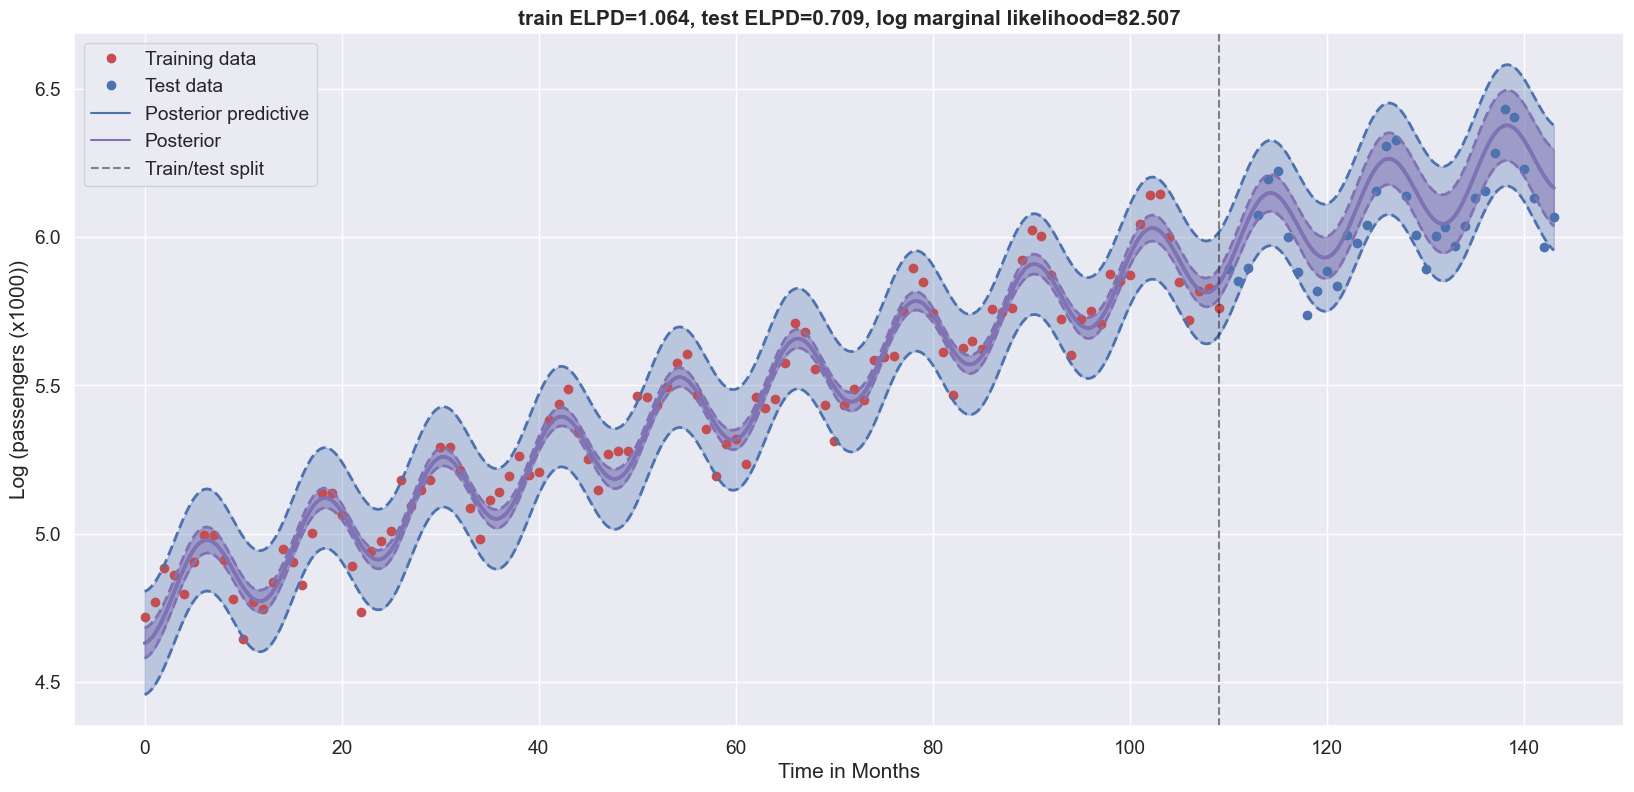

In [37]:
# we use the expected log predictive distribution as performance metric
def compute_elpd(y, mu, s2):
    """
    Computes the expected log predictive density (ELPD) for a set of predictions.
    ELPD is a performance metric that averages the log probability of the observed data
    under the model's predictive distribution, taking uncertainty into account.

    Equation:
        ELPD = (1/M) * sum_{i=1}^M log N(y_i | mu_i, s2_i)
        where N(y_i | mu_i, s2_i) is the normal density with mean mu_i and variance s2_i.

    Input shapes:
        y   : (M, 1) or (M,)   - observed values
        mu  : (M, 1) or (M,)   - predictive means
        s2  : (M, 1) or (M,)   - predictive variances

    Output:
        elpd: scalar           - average log predictive density
    """
    return jnp.mean(log_npdf(y.ravel(), mu.ravel(), s2.ravel()))

# Creates design matrix Phi based on input
def design_matrix(x):
    """
    Constructs the design matrix for the regression model.
    Each row corresponds to a data point, and each column to a basis function.

    Example (current):
        Phi = [1, x, x^2, cos(2*pi*x/12)]
        - 1: intercept
        - x: linear trend
        - x^2: quadratic trend
        - cos(2*pi*x/12): seasonal (annual) component

    Input:
        x: (N,) or (N, 1) - input values (e.g., months)

    Output:
        Phi: (N, D)       - design matrix (N samples, D features)
    """
    # Uncomment the line below to use a different model (e.g., linear, quadratic, etc.)
    # return jnp.column_stack((jnp.ones(len(x)), x))
    # return jnp.column_stack((jnp.ones(len(x)), x, x**2))
    return jnp.column_stack((jnp.ones(len(x)), x, x**2, jnp.cos(2*jnp.pi*x/12)))

# prepare input data for prediction and fitting
xpred = jnp.linspace(0, 143, 500)  # (500,) - prediction points (months)
Phi_train = design_matrix(xtrain)   # (Ntrain, D) - design matrix for training set
Phi_test = design_matrix(xtest)     # (Ntest, D)  - design matrix for test set
Phi_pred = design_matrix(xpred)     # (500, D)    - design matrix for prediction grid

# fit model
model = BayesianLinearRegression(Phi_train, ytrain, alpha=1, beta=1)
model.optimize_hyperparameters()  # maximize marginal likelihood for alpha, beta
logZ = model.log_marginal_likelihood  # log marginal likelihood (scalar)

# make predictions for plotting
ypred_mu, ypred_s2 = model.predict_f(Phi_pred)   # (500,), (500,) - mean/var of latent function f(x)
tpred_mu, tpred_s2 = model.predict_y(Phi_pred)   # (500,), (500,) - mean/var of predictive y(x)

# make predictions for training and test set & evaluate performance metrics
ytrain_mu, ytrain_s2 = model.predict_y(Phi_train)  # (Ntrain,), (Ntrain,)
ytest_mu, ytest_s2 = model.predict_y(Phi_test)     # (Ntest,), (Ntest,)
train_elpd = compute_elpd(ytrain, ytrain_mu, ytrain_s2)  # scalar
test_elpd = compute_elpd(ytest, ytest_mu, ytest_s2)      # scalar

# plot
fig, ax = plt.subplots(1, 1, figsize=(20,9))
plot_data(ax)  # plot training/test data
plot_predictions(ax, xpred, tpred_mu, tpred_s2, color='b', label='Posterior predictive', visibility=0.3)
plot_predictions(ax, xpred, ypred_mu, ypred_s2, color='m', label='Posterior')
ax.set_title('train ELPD=%4.3f, test ELPD=%4.3f, log marginal likelihood=%4.3f' % (train_elpd, test_elpd, logZ), fontweight='bold')
ax.axvline(xtrain[-1], color='k', linestyle='--', alpha=0.5, label='Train/test split')
ax.legend()

**Task 4.1**: Run the code with $\alpha = 10$ and $\beta = 1$ as initial values. Comment on the quality of the fit. Note the values of the negative log likelihood for the training and test set.


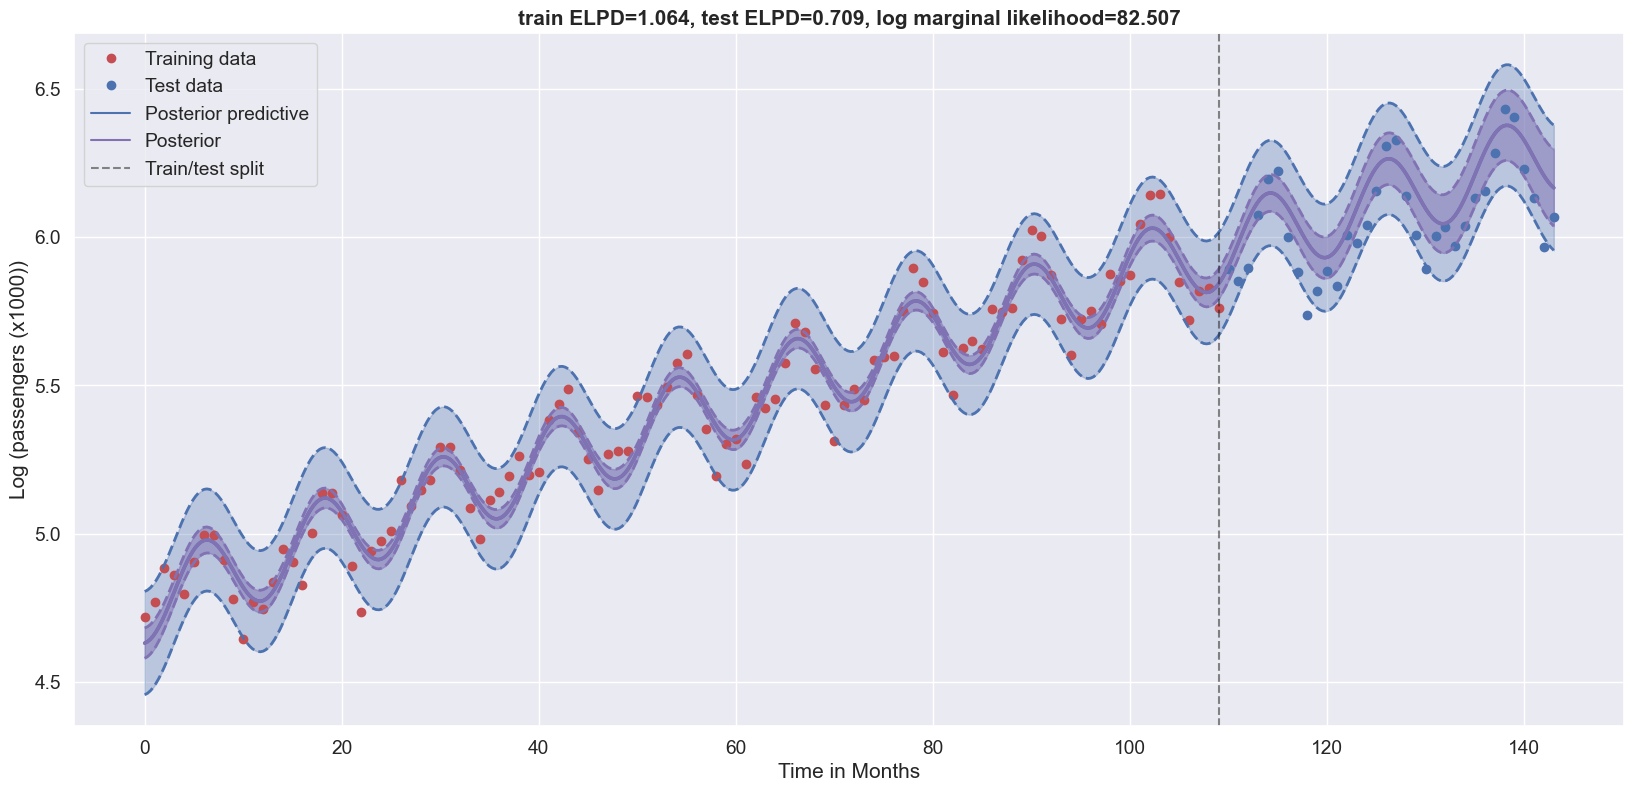

In [38]:
# prepare input data for prediction and fitting
xpred = jnp.linspace(0, 143, 500)  # (500,) - prediction points (months)
Phi_train = design_matrix(xtrain)   # (Ntrain, D) - design matrix for training set
Phi_test = design_matrix(xtest)     # (Ntest, D)  - design matrix for test set
Phi_pred = design_matrix(xpred)     # (500, D)    - design matrix for prediction grid

# fit model
model = BayesianLinearRegression(Phi_train, ytrain, alpha=10, beta=1)
model.optimize_hyperparameters()  # maximize marginal likelihood for alpha, beta
logZ = model.log_marginal_likelihood  # log marginal likelihood (scalar)

# make predictions for plotting
ypred_mu, ypred_s2 = model.predict_f(Phi_pred)   # (500,), (500,) - mean/var of latent function f(x)
tpred_mu, tpred_s2 = model.predict_y(Phi_pred)   # (500,), (500,) - mean/var of predictive y(x)

# make predictions for training and test set & evaluate performance metrics
ytrain_mu, ytrain_s2 = model.predict_y(Phi_train)  # (Ntrain,), (Ntrain,)
ytest_mu, ytest_s2 = model.predict_y(Phi_test)     # (Ntest,), (Ntest,)
train_elpd = compute_elpd(ytrain, ytrain_mu, ytrain_s2)  # scalar
test_elpd = compute_elpd(ytest, ytest_mu, ytest_s2)      # scalar

# plot
fig, ax = plt.subplots(1, 1, figsize=(20,9))
plot_data(ax)  # plot training/test data
plot_predictions(ax, xpred, tpred_mu, tpred_s2, color='b', label='Posterior predictive', visibility=0.3)
plot_predictions(ax, xpred, ypred_mu, ypred_s2, color='m', label='Posterior')
ax.set_title('train ELPD=%4.3f, test ELPD=%4.3f, log marginal likelihood=%4.3f' % (train_elpd, test_elpd, logZ), fontweight='bold')
ax.axvline(xtrain[-1], color='k', linestyle='--', alpha=0.5, label='Train/test split')
ax.legend()


**Task 4.2**: Estimate $\alpha, \beta$ by optimizing the marginal likelihood by uncommenting the line, which calls the function *optimize_hyperparameters()*. Report the estimates for $\alpha$ and $\beta$.

**Solution**

In [39]:
print(f'Alpha: {model.alpha:4.3f}')
print(f'Beta:  {model.beta:4.3f} (sigma2 = {1./model.beta:4.3f})' )

Alpha: 0.176
Beta:  138.631 (sigma2 = 0.007)


**End of solution**

**Task 4.3**: Experiment with different linear models but the uncommenting different lines in the *design_matrix()* function. Comment on the train/test ELPDs as well as the marginal likelihood.


**Task 4.4**: Comment on uncertainty estimates for the training and test set.

**Task 4.5**: Compute and visualize the posterior and the posterior predictive distribution for the logarithm of the number of customers after 145 months?

**Solution**

[Text(0.5, 0, 'Log Passengers ')]

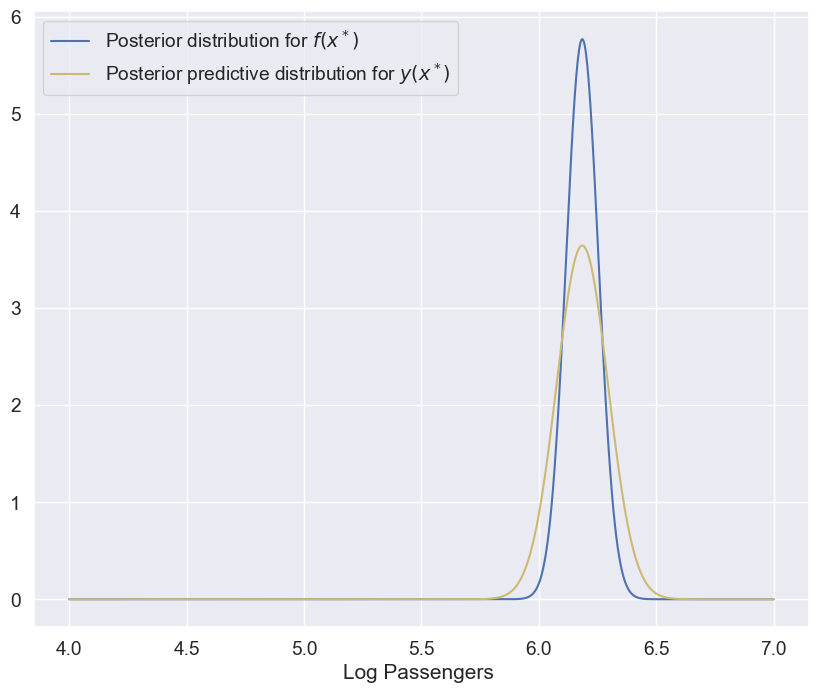

In [42]:
# Predictive distribution for the logarithm of the number of passengers after 145 months

# Input:
#   xstar: scalar, the month for prediction (here, 145)
#   design_matrix: function to create feature vector for xstar
#   model: trained BayesianLinearRegression model
# Output:
#   fstar_mu: posterior mean of latent function f(x*) at xstar, shape (1,)
#   fstar_s2: posterior variance of f(x*) at xstar, shape (1,)
#   ystar_mu: posterior predictive mean of y(x*) at xstar, shape (1,)
#   ystar_s2: posterior predictive variance of y(x*) at xstar, shape (1,)

xstar = 145
Phi_star = design_matrix(jnp.array([xstar]))  # shape: (1, D)

# Compute posterior mean and variance for latent function f(x*) and predictive y(x*)
# Equations:
#   f(x*) | data ~ N(fstar_mu, fstar_s2)
#   y(x*) | data ~ N(ystar_mu, ystar_s2)
#   fstar_mu = Phi_star @ m
#   fstar_s2 = Phi_star @ S @ Phi_star.T
#   ystar_mu = fstar_mu
#   ystar_s2 = fstar_s2 + 1/beta
fstar_mu, fstar_s2 = model.predict_f(Phi_star)    # shapes: (1,), (1,)
ystar_mu, ystar_s2 = model.predict_y(Phi_star)    # shapes: (1,), (1,)

# Create a grid for plotting the densities
fs = jnp.linspace(4, 7, 1000)  # grid for latent function f(x*)
ys = jnp.linspace(4, 7, 1000)  # grid for predictive y(x*)

# Normal PDF function for plotting
# Input shapes: x: (n,), m: scalar or (1,), v: scalar or (1,)
# Output shape: (n,)
npdf = lambda x, m, v: jnp.exp(-(x-m)**2/(2*v))/jnp.sqrt(2*jnp.pi*v)

# Plot the posterior and posterior predictive distributions
fig, ax = plt.subplots(figsize=(10, 8))
# Posterior for latent function f(x*)
ax.plot(ys, npdf(ys, fstar_mu, fstar_s2), label='Posterior distribution for $f(x^*)$', color='b')
# Posterior predictive for observed y(x*)
ax.plot(ys, npdf(ys, ystar_mu, ystar_s2), label='Posterior predictive distribution for $y(x^*)$', color='y')
ax.legend(loc='upper left')
ax.set(xlabel='Log Passengers ')


**End of solution**

For statistical models like $y_n = f(\mathbf{x}_n) + e_n$, we typically refer to $e_n$ as noise, but another way to think about $e_n$ is that it represent the part of the signal we cannot explain by the model $f(\mathbf{x}_n)$. 

**Task 4.6**: If you get hired by an airline company, and they asked you to provide a 95% credibility interval for the number of log passengers after 145, would you use the posterior distribution $p(f_*|y, x_*)$ or the posterior predictive distribution $p(y_*|y, x_*)$? and why?

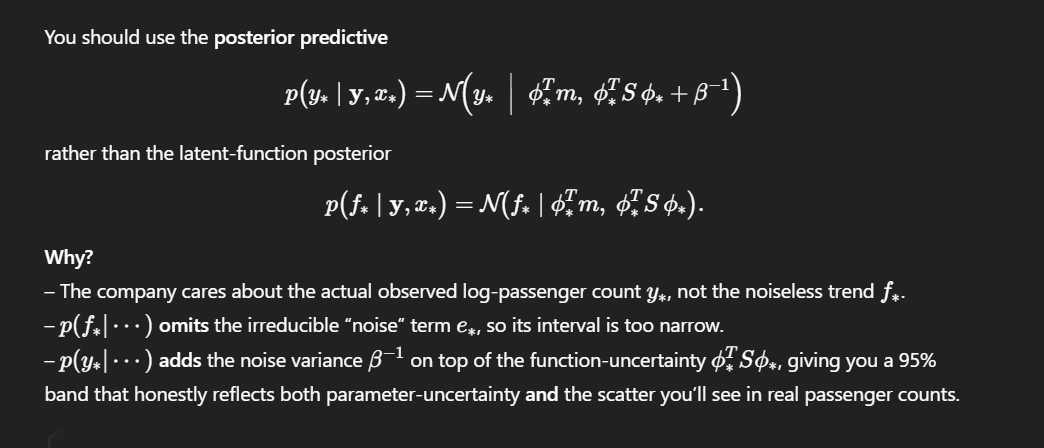

_________________

**Task 4.7**: Compute the predictive distribution for the number of passengers instead of the logarithm of the number of passengers. 

- Hints: You can either using sampling techniques or you use the fact that exponentiating a Gaussian random variable is a Log-Normal distribution with closed-form moments. See more here: [https://en.wikipedia.org/wiki/Log-normal_distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)

**Solution**

Let $y(x)$ denote the logarithm  of the number of passengers after x months and let $y(x)|\mathbf{y} \sim N(m, v)$ denote the predictive distribution for $y(x)$, then the number of passengers $P(x)$ is then given by 

$$\begin{align}
P(x) = \exp[y(x)]
\end{align}$$

Now because $\log P(x) \sim N(m, v)$, $P(x)$ is said to follow a log-normal distribution (https://en.wikipedia.org/wiki/Log-normal_distribution). 

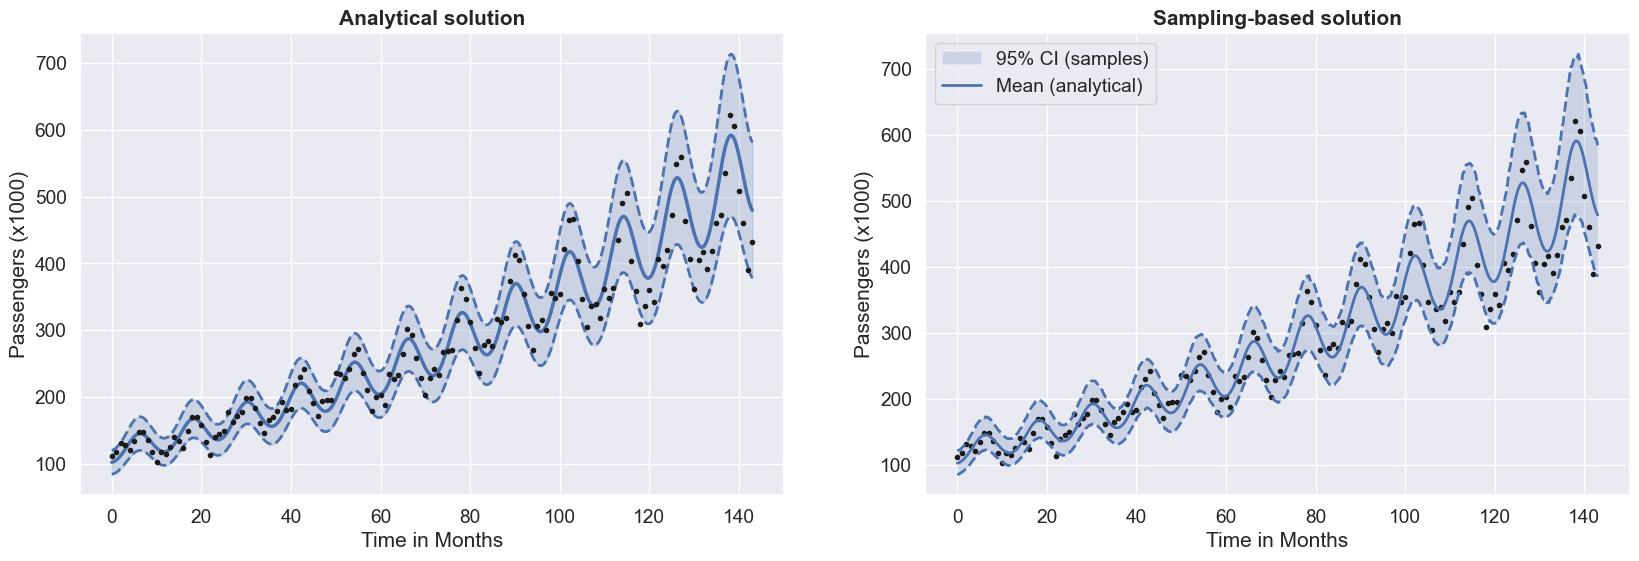

In [44]:
# prepare data and predict mean and variance for t(x)
# ypred_mu: (n_pred,) - predictive mean for log-passengers at each prediction point
# ypred_s2: (n_pred,) - predictive variance for log-passengers at each prediction point
ypred_mu, ypred_s2 = model.predict_y(Phi_pred)

################################################
# Analytical solution via log-normal 
################################################
# If y ~ N(m, v), then exp(y) ~ LogNormal(m, v)
# The mean and variance of exp(y) are:
#   E[exp(y)] = exp(m + 0.5*v)
#   Var[exp(y)] = (exp(v) - 1) * exp(2*m + v)
# Input shapes:
#   ypred_mu: (n_pred,)
#   ypred_s2: (n_pred,)
# Output shapes:
#   exp_y_mu: (n_pred,) - mean of predicted passengers
#   exp_y_s2: (n_pred,) - variance of predicted passengers

lognormal_mean = lambda m, v: jnp.exp(m + 0.5*v)
lognormal_var = lambda m, v: (jnp.exp(v) - 1)*jnp.exp(2*m + v)
exp_y_mu = lognormal_mean(ypred_mu.ravel(), ypred_s2.ravel()) 
exp_y_s2 = lognormal_var(ypred_mu.ravel(), ypred_s2.ravel()) 

################################################
# Sampling-based solution
################################################
# Draw samples from the posterior predictive distribution for y (log-passengers),
# then exponentiate to get samples for the number of passengers.
# Input:
#   ypred_mu: (n_pred,)
#   ypred_s2: (n_pred,)
# Output:
#   exp_y_samples: (num_samples, n_pred) - samples of predicted passengers

num_samples = 5000
key = random.PRNGKey(1)
# y_samples: (num_samples, n_pred) - samples from N(ypred_mu, ypred_s2)
y_samples = ypred_mu + jnp.sqrt(ypred_s2)*random.normal(key, shape=(num_samples, len(ypred_mu)))
# exp_y_samples: (num_samples, n_pred) - exponentiated samples (passengers)
exp_y_samples = jnp.exp(y_samples)

# Estimate 95% credibility intervals from samples
# lower, upper: (n_pred,) - 2.5th and 97.5th percentiles for each prediction point
lower = jnp.percentile(exp_y_samples, 2.5, axis=0)
upper = jnp.percentile(exp_y_samples, 97.5, axis=0)

################################################
# Plotting
################################################

# plot analytical solution (log-normal mean/variance)
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
# plot_predictions: plots mean and 95% CI using mean/variance
# Inputs: xpred (n_pred,), exp_y_mu (n_pred,), exp_y_s2 (n_pred,)
plot_predictions(ax[0], xpred, exp_y_mu, exp_y_s2, color='b', visibility=0.2)
ax[0].plot(months, passengers, 'k.')
ax[0].set_xlabel('Time in Months')
ax[0].set_ylabel('Passengers (x1000)')
ax[0].set_title('Analytical solution', fontweight='bold')

# plot sampling-based solution (sample percentiles)
ax[1].plot(months, passengers, 'k.')
ax[1].fill_between(xpred, lower, upper, alpha=0.2, label='95% CI (samples)')
ax[1].plot(xpred, exp_y_mu, 'b-', linewidth=2, label='Mean (analytical)')
ax[1].plot(xpred, lower, 'b--', xpred, upper, 'b--', linewidth=2)
ax[1].set_xlabel('Time in Months')
ax[1].set_ylabel('Passengers (x1000)')
ax[1].set_title('Sampling-based solution', fontweight='bold')
ax[1].legend()


**End of solution**